# Ground Zero

## Packages and Datasets

In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'researchpy', 'missingno', 'folium', 'pydotplus','bokeh','imblearn','xgboost','graphviz' }
missing = required - installedPackages
if missing:
    !pip install researchpy
    !pip install missingno
    !pip install folium
    !pip install pydotplus
    !pip install bokeh
    !pip install imblearn
    !pip install xgboost
    !pip install graphviz

In [2]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import timeit
start_time = timeit.default_timer()  #timestamp to calculate total runtime

import pandas as pd
import numpy as np

import researchpy as rp
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import scipy.stats as ss

import folium
from folium import plugins

from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn import tree
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, \
precision_score, recall_score, roc_auc_score, f1_score, precision_recall_curve, auc 

%matplotlib inline
pd.set_option('display.max_columns', None)  # prevent column output trancation
sns.set()  # change plot styling from Matlab's 90s feel to today's Seaborn.

In [4]:
# File Directories
path_crashes = '../crashes.sample2020.csv'
path_vehicles = '../vehicles.sample.csv'
path_people = '../people.sample.csv'

# Import samples
crashes = pd.read_csv(
    path_crashes,
    parse_dates=["CRASH_DATE", "CRASH_DATE_EST_I", "DATE_POLICE_NOTIFIED"],
    low_memory=False,
    dtype=object)

vehicles = pd.read_csv(path_vehicles,
                       parse_dates=["CRASH_DATE"],
                       low_memory=False,
                       dtype=object)

people = pd.read_csv(path_people,
                     parse_dates=["CRASH_DATE"],
                     low_memory=False,
                     dtype=object)

## Overview of Sprint 2
- Understanding of Feature Processes
- Data Merge & Split
- Feature Reduction & Missing Value Treatment
- Outliers
- Feature Engineering
- Baseline Model

## Our Understanding

### Feature Engineering Process

[Source](https://en.wikipedia.org/wiki/Feature_engineering)

The feature engineering process is:
- Brainstorming or testing features;
- Deciding what features to create;
- Creating features;
- Checking how the features work with your model;
- **Improving your features if needed;**
- Go back to brainstorming/creating more features until the work is done.

### Some Terms

[Source](https://datascience.stackexchange.com/questions/29006/feature-selection-vs-feature-extraction-which-to-use-when)

**Feature Extraction and Feature Engineering:** transformation of raw data into features suitable for modeling; 

- Texts(ngrams, word2vec, tf-idf etc)
- Geospatial data(lat, long)
- Date and time(day, month, week, year, rolling based)
- Time series, web, etc
- Dimensional Reduction Techniques (PCA, SVD, Eigen-Faces etc)
- Clustering (DBSCAN etc)
- And others.

---

**Feature / Data Transformation:** transformation of data to improve the accuracy of the algorithm;
- Normalization and changing distribution(Scaling)
- Interactions
- Handling missing Values
- Handling outliers
- Handling time-date / mixed variables
- Encoding categorical features
- Variable types 
- And others.

---

**Feature Selection:** removing unnecessary features.

- Statistical approaches
- Selection by modeling
- Grid search
- Cross Validation
- And others

---

For the purpose of workflow, we will split **Feature Selection** into; 
- **feature reduction** to remove unnecessary features, 
- and **feature selection** to select features by their importance scores through ML/statistical techniques.

# Data Merge & Split

## Merging datasets

The goal is to successfully merge all datasets by increasing crash records as little as possible.

In [5]:
print("Here is the initial shape of the three datasets:")
print("Crashes", crashes.shape)
print("Vehicles", vehicles.shape)
print("People", people.shape)

Here is the initial shape of the three datasets:
Crashes (33408, 49)
Vehicles (75673, 72)
People (82049, 30)


**Data Merge Strategy**

- Filter out passengers from **`people`**, and left-join it to **`vehicles`** on `CRASH_RECORD_ID`, `RD_NO`, `CRASH_DATE`, `VEHICLE_ID`.

- Then inner-join this dataset to **`crashes`** on `CRASH_RECORD_ID`, `RD_NO`, `CRASH_DATE`.

---

**Reasoning**

- `people` has **many-to-one relationship** with `vehicles` but a pedestrian in `vehicles` has **one-to-one** with `people`,

- Passengers don't have <u>a trajectory separate from the unit</u> they belong to and they don't contribute to accidents with their existence but they are involved if they got harmed through `injuries` features,

- This method increases `crashes` records **only per active parties involved**.

In [6]:
# Filter only non-pessenger people (drivers, pedestrian, cyclist, etc.)
non_passengers = people[people.PERSON_ID.str.contains('^O')]

In [7]:
# Left join non-peseenger people with vehicles
vehicles_with_people = vehicles.merge(non_passengers, 
                                      how='left', 
                                      on=['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE', 'VEHICLE_ID'])
vehicles_with_people.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,RD_NO,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS,PERSON_ID,PERSON_TYPE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,228894,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,1,DRIVER,NaN,224185,NaN,DODGE,CHARGER,IL,2012,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,Y,NaN,1,NaN,PRIVATE TOW,UNKNOWN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O228894,DRIVER,NaN,KANKAKKE,IL,60901,M,18,IL,D,SAFETY BELT USED,"DEPLOYED, FRONT",NONE,NONINCAPACITATING INJURY,NaN,NaN,NaN,UNKNOWN,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,228895,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,2,PARKED,NaN,224187,NaN,GENERAL MOTORS CORP.,YUKON,IL,2003,UNKNOWN,PASSENGER,PERSONAL,N,PARKED,Y,NaN,0,NaN,PRIVATE TOW,UNKNOWN,N,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,228896,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,3,PARKED,NaN,224191,NaN,SATURN,UNKNOWN,IL,2000,UNKNOWN,PASSENGER,PERSONAL,N,PARKED,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR-RIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,228905,f7210aec9ac43a7b36c30b49033adebcb3060b96580341...,JA453640,2017-10-01 02:41:00,1,DRIVER,NaN,224199,NaN,FORD,WINDSTAR,IL,2007,NONE,VAN/MINI-VAN,PERSONAL,E,STRAIGHT AHEAD,Y,NaN,1,NaN,NaN,NaN,NaN,Y,Y,Y,Y,NaN,N,N,N,NaN,NaN,Y,NaN,NaN,TOTAL (ALL AREAS),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O228905,DRIVER,NaN,CHICAGO,IL,60632,M,43,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,IMPROPER LANE CHANGE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,228906,f7210aec9ac43a7b36c30b49033adebcb3060b96580341...,JA453640,2017-10-01 02:41:00,2,DRIVERLESS,NaN,224203,NaN,CHEVROLET,CRUZE,IL,2012,NONE,PASSENGER,NOT IN USE,UNKNOWN,PARKED,Y,NaN,0,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,Y,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print("Shape of vehicles with people", vehicles_with_people.shape)

Shape of vehicles with people (75838, 98)


In [9]:
merged_data = crashes.merge(vehicles_with_people, 
                            how='inner', 
                            on=['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE'])

print('Dimensions of the data after merging', merged_data.shape)

Dimensions of the data after merging (68503, 144)


**Inspection 1**

In [10]:
merged_data.groupby('CRASH_RECORD_ID').head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_UNIT_ID,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS,PERSON_ID,PERSON_TYPE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667550,1,DRIVER,NaN,635502,NaN,CHEVROLET,EQUINOX,IL,2017,UNKNOWN,SPORT UTILITY VEHICLE (SUV),UNKNOWN/NA,W,STRAIGHT AHEAD,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667550,DRIVER,NaN,HOMEWOOD,IL,60430,F,56,IL,D,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667551,2,DRIVER,1,635496,NaN,CHEVROLET,SILVERADO,IL,2016,NONE,PICKUP,PERSONAL,W,STARTING IN TRAFFIC,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667551,DRIVER,NaN,PALOS HILLS,IL,60465,M,51,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST 

**Inspection 2**

In [11]:
print("Wrong joins could have resulted in 6 rows. Here we see 2 rows, meaning the join was successful.")
merged_data[merged_data.RD_NO=='JC301403'] #Wrong joins could result in 6 rows

Wrong joins could have resulted in 6 rows. Here we see 2 rows, meaning the join was successful.


,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_UNIT_ID,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS,PERSON_ID,PERSON_TYPE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667550,1,DRIVER,NaN,635502,NaN,CHEVROLET,EQUINOX,IL,2017,UNKNOWN,SPORT UTILITY VEHICLE (SUV),UNKNOWN/NA,W,STRAIGHT AHEAD,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667550,DRIVER,NaN,HOMEWOOD,IL,60430,F,56,IL,D,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667551,2,DRIVER,1,635496,NaN,CHEVROLET,SILVERADO,IL,2016,NONE,PICKUP,PERSONAL,W,STARTING IN TRAFFIC,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667551,DRIVER,NaN,PALOS HILLS,IL,60465,M,51,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST 

## Splitting the data

In [12]:
# Alternative: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
raw_train, raw_test = train_test_split(merged_data, test_size=0.20, random_state=42, shuffle=True)

In [13]:
print("Train shape", raw_train.shape)
print("Test shape", raw_test.shape)

Train shape (54802, 144)
Test shape (13701, 144)


**Write datasets as csv**

In [14]:
# save the train and test file
#train.to_csv('~/repos/vision_zero_chicago_project/sprint 2/raw_train.csv')
#test.to_csv('~/repos/vision_zero_chicago_project/sprint 2/raw_test.csv')

# Feature Reduction

## Detailed look at all features

In [15]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54802 entries, 29244 to 15795
Columns: 144 entries, CRASH_RECORD_ID to CELL_PHONE_USE
dtypes: datetime64[ns](2), object(142)
memory usage: 60.6+ MB


| **Feature** | **Description** | **Decision to drop** |
|:-----|:----:|----:|
| CRASH_RECORD_ID | This number can be used to link to the same crash in the Vehicles and People datasets. This number also serves as a unique ID in this dataset. | NO |
| RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes. | YES |
| CRASH_DATE_EST_I | Crash date estimated by desk officer or reporting party (only used in cases where crash is reported at police station days after the crash) | YES |
| CRASH_DATE | Date and time of crash as entered by the reporting officer | NO |
| POSTED_SPEED_LIMIT | Posted speed limit, as determined by reporting officer | NO |
| TRAFFIC_CONTROL_DEVICE | Traffic control device present at crash location, as determined by reporting officer | NO |
| DEVICE_CONDITION | Condition of traffic control device, as determined by reporting officer | NO |
| WEATHER_CONDITION | Weather condition at time of crash, as determined by reporting officer | NO |
| LIGHTING_CONDITION | Light condition at time of crash, as determined by reporting officer | NO |
| FIRST_CRASH_TYPE | Type of first collision in crash | NO |
| TRAFFICWAY_TYPE | Trafficway type, as determined by reporting officer | NO |
| LANE_CNT | Total number of through lanes in either direction, excluding turn lanes, as determined by reporting officer (0 = intersection) | NO |
| ALIGNMENT | Street alignment at crash location, as determined by reporting officer | NO |
| ROADWAY_SURFACE_COND | Road surface condition, as determined by reporting officer | NO |
| ROAD_DEFECT | Road defects, as determined by reporting officer | NO |
| REPORT_TYPE | Administrative report type (at scene, at desk, amended) | YES |
| CRASH_TYPE | A general severity classification for the crash. Can be either Injury and/or Tow Due to Crash or No Injury / Drive Away | NO |
| INTERSECTION_RELATED_I |A field observation by the police officer whether an intersection played a role in the crash. Does not represent whether or not the crash occurred within the intersection. | NO |
| NOT_RIGHT_OF_WAY_I | Whether the crash begun or first contact was made outside of the public right-of-way. | NO |
| HIT_AND_RUN_I | Crash did/did not involve a driver who caused the crash and fled the scene without exchanging information and/or rendering aid | NO |
| DAMAGE | A field observation of estimated damage. | NO |
| DATE_POLICE_NOTIFIED | Calendar date on which police were notified of the crash | YES |
| PRIM_CONTRIBUTORY_CAUSE | The factor which was most significant in causing the crash, as determined by officer judgment | NO |
| SEC_CONTRIBUTORY_CAUSE | The factor which was second most significant in causing the crash, as determined by officer judgment | NO |
| STREET_NO | Street address number of crash location, as determined by reporting officer | NO |
| STREET_DIRECTION | Street address direction (N,E,S,W) of crash location, as determined by reporting officer | NO |
| STREET_NAME | Street address name of crash location, as determined by reporting officer | NO |
| BEAT_OF_OCCURRENCE | Chicago Police Department Beat ID | YES |
| PHOTOS_TAKEN_I | Whether the Chicago Police Department took photos at the location of the crash | YES |
| STATEMENTS_TAKEN_I | Whether statements were taken from unit(s) involved in crash | YES |
| DOORING_I | Whether crash involved a motor vehicle occupant opening a door into the travel path of a bicyclist, causing a crash | NO |
| WORK_ZONE_I | Whether the crash occurred in an active work zone | NO |
| WORK_ZONE_TYPE | The type of work zone, if any | YES |
| WORKERS_PRESENT_I | Whether construction workers were present in an active work zone at crash location | YES |
| NUM_UNITS | Number of units involved in the crash. A unit can be a motor vehicle, a pedestrian, a bicyclist, or another non-passenger roadway user. Each unit represents a mode of traffic with an independent trajectory. | NO |
| MOST_SEVERE_INJURY | Most severe injury sustained by any person involved in the crash | NO |
| INJURIES_TOTAL | Total persons sustaining fatal, incapacitating, non-incapacitating, and possible injuries as determined by the reporting officer | NO |
| INJURIES_FATAL | Total persons sustaining fatal injuries in the crash | NO |
| INJURIES_INCAPACITATING | Total persons sustaining incapacitating/serious injuries in the crash as determined by the reporting officer. Any injury other than fatal injury, which prevents the injured person from walking, driving, or normally continuing the activities they were capable of performing before the injury occurred. Includes severe lacerations, broken limbs, skull or chest injuries, and abdominal injuries. | NO |
| INJURIES_NON_INCAPACITATING | Total persons sustaining non-incapacitating injuries in the crash as determined by the reporting officer. Any injury, other than fatal or incapacitating injury, which is evident to observers at the scene of the crash. Includes lump on head, abrasions, bruises, and minor lacerations. | NO |
| INJURIES_REPORTED_NOT_EVIDENT | Total persons sustaining possible injuries in the crash as determined by the reporting officer. Includes momentary unconsciousness, claims of injuries not evident, limping, complaint of pain, nausea, and hysteria. | NO |
| INJURIES_NO_INDICATION | Total persons sustaining no injuries in the crash as determined by the reporting officer | YES |
| INJURIES_UNKNOWN | Total persons for whom injuries sustained, if any, are unknown | YES |
| CRASH_HOUR | The hour of the day component of CRASH_DATE. | NO |
| CRASH_DAY_OF_WEEK | The day of the week component of CRASH_DATE. Sunday=1 | YES |
| CRASH_MONTH | The month component of CRASH_DATE. | YES |
| LATITUDE | The latitude of the crash location, as determined by reporting officer, as derived from the reported address of crash | NO |
| LONGITUDE | The longitude of the crash location, as determined by reporting officer, as derived from the reported address of crash | NO |
| LOCATION | The crash location, as determined by reporting officer, as derived from the reported address of crash, in a column type that allows for mapping and other geographic analysis in the data portal software | YES || PERSON_ID | A unique identifier for each person record. IDs starting with P indicate passengers. IDs starting with O indicate a person who was not a passenger in the vehicle (e.g., driver, pedestrian, cyclist, etc.). | NO |
| PERSON_TYPE | Type of roadway user involved in crash | NO |
| CRASH_RECORD_ID | This number can be used to link to the same crash in the Crashes and Vehicles datasets. This number also serves as a unique ID in the Crashes dataset. | NO |
| RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes. | YES |
| VEHICLE_ID | The corresponding CRASH_UNIT_ID from the Vehicles dataset. | YES |
| CRASH_DATE | Date and time of crash as entered by the reporting officer | YES |
| SEAT_NO | Code for seating position of motor vehicle occupant: 1= driver, 2= center front, 3 = front passenger, 4 = second row left, 5 = second row center, 6 = second row right, 7 = enclosed passengers, 8 = exposed passengers, 9= unknown position, 10 = third row left, 11 = third row center, 12 = third row right | YES |
| CITY | City of residence of person involved in crash | NO |
| STATE | State of residence of person involved in crash | YES |
| ZIPCODE | ZIP Code of residence of person involved in crash | YES |
| SEX | Gender of person involved in crash, as determined by reporting officer | NO |
| AGE | Age of person involved in crash | NO |
| DRIVERS_LICENSE_STATE | State issuing driver's license of person involved in crash | YES |
| DRIVERS_LICENSE_CLASS| Class of driver's license of person involved in crash | YES |
| SAFETY_EQUIPMENT | Safety equipment used by vehicle occupant in crash, if any | NO |
| AIRBAG_DEPLOYED | Whether vehicle occupant airbag deployed as result of crash | NO |
| EJECTION | Whether vehicle occupant was ejected or extricated from the vehicle as a result of crash | NO |
| INJURY_CLASSIFICATION | Severity of injury person sustained in the crash | YES |
| HOSPITAL | Hospital to which person injured in the crash was taken | YES |
| EMS_AGENCY | EMS agency who transported person injured in crash to the hospital | YES |
| EMS_RUN_NO | EMS agency run number | YES |
| DRIVER_ACTION | Driver action that contributed to the crash, as determined by reporting officer | NO |
| DRIVER_VISION | What, if any, objects obscured the driver’s vision at time of crash | NO |
| PHYSICAL_CONDITION | Driver’s apparent physical condition at time of crash, as observed by the reporting officer | NO |
| PEDPEDAL_ACTION | Action of pedestrian or cyclist at the time of crash | NO |
| PEDPEDAL_VISIBILITY | Visibility of pedestrian of cyclist safety equipment in use at time of crash | NO |
| PEDPEDAL_LOCATION | Location of pedestrian or cyclist at the time of crash | YES |
| BAC_RESULT | Status of blood alcohol concentration testing for driver or other person involved in crash | YES |
| BAC_RESULT VALUE | Driver’s blood alcohol concentration test result | NO |
| CELL_PHONE_USE | Whether person was/was not using cellphone at the time of the crash, as determined by the reporting officer | NO |
|CRASH_UNIT_ID | A unique identifier for each vehicle record | YES | 
|CRASH_RECORD_ID | This number can be used to link to the same crash in the Crashes and People datasets. This number also serves as a unique ID in the Crashes dataset | NO | 
|RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes | Yes | 
|CRASH_DATE| Date and time of crash as entered by the reporting officer | No | 
|UNIT_NO| A unique ID for each unit within a specific crash report | Yes | 
|UNIT_TYPE| Type of unit | Yes | 
|NUM_PASSENGERS| Number of passengers in the vehicle. The driver is not included. More information on passengers is in the People dataset | No | 
|VEHICLE_ID| No definition | Yes | 
|CMRC_VEH_I| No definition | Yes | 
|MAKE| The make (brand) of the vehicle, if relevant | YES | 
|MODEL| The model of the vehicle, if relevant| NO | 
|LIC_PLATE_STATE| The state issuing the license plate of the vehicle, if relevant | No | 
|VEHICLE_YEAR| The model year of the vehicle, if relevant | No | 
|VEHICLE_DEFECT| No definition | No | 
|VEHICLE_TYPE| The type of vehicle, if relevant | No | 
|TRAVEL_DIRECTION| The direction in which the unit was traveling prior to the crash, as determined by the reporting officer | No | 
|MANEUVER| The action the unit was taking prior to the crash, as determined by the reporting officer | NO | 
|TOWED_I| Indicator of whether the vehicle was towed | Yes | 
|FIRE_I| No definition | Yes | 
|OCCUPANT_COUNT| The number of people in the unit, as determined by the reporting officer | No | 
|EXCEED_SPEED_LIMIT_I| Indicator of whether the unit was speeding, as determined by the reporting officer | No | 
|TOWED_BY| No definition | Yes | 
|TOWED_TO| No definition | Yes | 
|AREA_00_I:AREA_99_I| No definition | Yes | 
|FIRST_CONTACT_POINT| No definition | No | 
|CMV_ID:HAZMAT_CLASS| No definition | Yes |


**Features to be excluded are**
- `RD_NO`
- `CRASH_DATE_EST_I`
- `REPORT_TYPE`
- `CRASH_DATE_EST_I`
- `REPORT_TYPE`
- `CRASH_TYPE`
- `NOT_RIGHT_OF_WAY_I`
- `DATE_POLICE_NOTIFIED`
- `STREET_DIRECTION`
- `ALIGNMENT`
- `BEAT_OF_OCCURRENCE`
- `PHOTOS_TAKEN_I`
- `STATEMENTS_TAKEN_I`
- `DOORING_I`
- `WORK_ZONE_I`
- `WORK_ZONE_TYPE`
- `WORKERS_PRESENT_I`
- `MOST_SEVERE_INJURY`
- `INJURIES_NO_INDICATION`
- `INJURIES_UNKNOWN`
- `CRASH_DAY_OF_WEEK`
- `CRASH_MONTH`
- `LATITUDE`
- `LONGITUDE`
- `RD_NO`
- `VEHICLE_ID`
- `CRASH_DATE`
- `SEAT_NO`
- `CITY`
- `STATE`
- `ZIPCODE`
- `DRIVERS_LICENSE_STATE`
- `DRIVERS_LICENSE_CLASS`
- `INJURY_CLASSIFICATION`
- `HOSPITAL`
- `EMS_AGENCY`
- `EMS_RUN_NO`
- `PEDPEDAL_ACTION`	
- `PEDPEDAL_VISIBILITY`
- `PEDPEDAL_LOCATION`
- `BAC_RESULT`
- `BAC_RESULT VALUE`
- `CRASH_UNIT_ID`
- `RD_NO`
- `UNIT_NO`
- `UNIT_TYPE`
- `VEHICLE_ID`
- `CMRC_VEH_I`
- `MAKE`
- `MODEL`
- `TOWED_I`
- `FIRE_I`
- `TOWED_BY`
- `TOWED_TO`
- `AREA_00_I`
- `AREA_01_I`
- `AREA_02_I`
- `AREA_03_I`
- `AREA_04_I`
- `AREA_05_I`
- `AREA_06_I`
- `AREA_07_I`
- `AREA_08_I`
- `AREA_09_I`
- `AREA_10_I`
- `AREA_11_I`
- `AREA_12_I`
- `AREA_99_I`
- `CMV_ID:HAZMAT_CLASS`




**Due to the reasons**
- Redundant information
- Non value information (at least for our baseline model)

In [16]:
# Drop the features that are not needed
feature_drop_train = ["CRASH_DATE_EST_I", "REPORT_TYPE", "CRASH_DATE_EST_I", "REPORT_TYPE", 
                      "DATE_POLICE_NOTIFIED","BEAT_OF_OCCURRENCE", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I", 
                      "WORK_ZONE_TYPE", "WORKERS_PRESENT_I","INJURIES_NO_INDICATION", "INJURIES_UNKNOWN",
                      "CRASH_DAY_OF_WEEK", "CRASH_MONTH", "RD_NO", "VEHICLE_ID", "CRASH_RECORD_ID",
                      "SEAT_NO", "STATE", "ZIPCODE", "DRIVERS_LICENSE_STATE", "PERSON_ID",
                      "DRIVERS_LICENSE_CLASS", "INJURY_CLASSIFICATION", "HOSPITAL", "EMS_AGENCY", 
                      "EMS_RUN_NO", "PEDPEDAL_LOCATION", "LOCATION","DAMAGE","CRASH_TYPE","MODEL",
                      "BAC_RESULT", "CRASH_UNIT_ID", "RD_NO", "UNIT_NO", "UNIT_TYPE", "VEHICLE_ID", 
                      "CMRC_VEH_I", "MAKE", "TOWED_I", "FIRE_I", "TOWED_BY", "STREET_NO","STREET_NAME",
                      "TOWED_TO", "AREA_00_I", "AREA_01_I", "AREA_02_I", "AREA_03_I", "AREA_04_I", 
                      "AREA_05_I", "AREA_06_I", "AREA_07_I", "AREA_08_I", "AREA_09_I", "AREA_10_I", 
                      "AREA_11_I", "AREA_12_I", "AREA_99_I", "CMV_ID", "USDOT_NO", "CCMC_NO", 
                      "ILCC_NO", "COMMERCIAL_SRC", "GVWR", "CARRIER_NAME", "CARRIER_STATE", "CARRIER_CITY",
                      "HAZMAT_PLACARDS_I", "HAZMAT_NAME", "UN_NO", "HAZMAT_PRESENT_I", "HAZMAT_REPORT_I",
                      "HAZMAT_REPORT_NO", "MCS_REPORT_I", "MCS_REPORT_NO", "HAZMAT_VIO_CAUSE_CRASH_I", 
                      "MCS_VIO_CAUSE_CRASH_I", "IDOT_PERMIT_NO", "WIDE_LOAD_I", "TRAILER1_WIDTH", 
                      "TRAILER2_WIDTH", "TRAILER1_LENGTH", "TRAILER2_LENGTH", "TOTAL_VEHICLE_LENGTH",
                      "AXLE_CNT", "VEHICLE_CONFIG", "CARGO_BODY_TYPE", "LOAD_TYPE", "HAZMAT_OUT_OF_SERVICE_I",
                      "INJURIES_FATAL","INJURIES_INCAPACITATING","INJURIES_NON_INCAPACITATING","INJURIES_REPORTED_NOT_EVIDENT",
                      "MCS_OUT_OF_SERVICE_I", "HAZMAT_CLASS"]

train = raw_train.loc[:, ~raw_train.columns.isin(feature_drop_train)]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54802 entries, 29244 to 15795
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CRASH_DATE               54802 non-null  datetime64[ns]
 1   POSTED_SPEED_LIMIT       54802 non-null  object        
 2   TRAFFIC_CONTROL_DEVICE   54802 non-null  object        
 3   DEVICE_CONDITION         54802 non-null  object        
 4   WEATHER_CONDITION        54802 non-null  object        
 5   LIGHTING_CONDITION       54802 non-null  object        
 6   FIRST_CRASH_TYPE         54802 non-null  object        
 7   TRAFFICWAY_TYPE          54802 non-null  object        
 8   LANE_CNT                 18076 non-null  object        
 9   ALIGNMENT                54802 non-null  object        
 10  ROADWAY_SURFACE_COND     54802 non-null  object        
 11  ROAD_DEFECT              54802 non-null  object        
 12  INTERSECTION_RELATED_I   133

**Replacing below level categories to NAN**

- TRAFFIC_CONTROL_DEVICE- UNKNOWN, OTHER
- DEVICE_CONDITION - UNKNOWN, OTHER
- WEATHER_CONDITION - UNKNOWN, OTHER
- LIGHTING_CONDITION - UNKNOWN
- TRAFFICWAY_TYPE - UNKNOWN, OTHER
- ROADWAY_SURFACE_COND - UNKNOWN, OTHER
- ROAD_DEFECT - UNKNOWN, OTHER
- PRIM_CONTRIBUTORY_CAUSE- UNABLE TO DETERMINE
- SEC_CONTRIBUTORY_CAUSE - UNABLE TO DETERMINE
- MODEL - UNKNOWN
- VEHICLE_DEFECT - UNKNOWN, OTHER
- VEHICLE_TYPE - UNKNOWN/NA
- TRAVEL_DIRECTION - UNKNOWN
- MANEUVER - UNKNOWN/NA
- SEX - X
- SAFETY_EQUIPMENT - USAGE UNKNOWN
- AIRBAG_DEPLOYED - DEPLOYMENT UNKNOWN
- EJECTION - UNKNOWN
- DRIVER_ACTION - UNKNOWN
- DRIVER_VISION - UNKNOWN
- PHYSICAL_CONDITION - UNKNOWN
- PEDPEDAL_ACTION - UNKNOWN/NA 

In [17]:
train.loc[train["TRAFFIC_CONTROL_DEVICE"]=="UNKNOWN","TRAFFIC_CONTROL_DEVICE"]=np.nan
train.loc[train["DEVICE_CONDITION"]=="UNKNOWN","DEVICE_CONDITION"]=np.nan
train.loc[train["WEATHER_CONDITION"]=="UNKNOWN","WEATHER_CONDITION"]=np.nan
train.loc[train["LIGHTING_CONDITION"]=="UNKNOWN","LIGHTING_CONDITION"]=np.nan
train.loc[train["TRAFFICWAY_TYPE"]=="UNKNOWN","TRAFFICWAY_TYPE"]=np.nan
train.loc[train["ROADWAY_SURFACE_COND"]=="UNKNOWN","ROADWAY_SURFACE_COND"]=np.nan
train.loc[train["ROAD_DEFECT"]=="UNKNOWN","ROAD_DEFECT"]=np.nan

train.loc[train["VEHICLE_DEFECT"]=="UNKNOWN","VEHICLE_DEFECT"]=np.nan
train.loc[train["VEHICLE_TYPE"]=="UNKNOWN/NA","VEHICLE_TYPE"]=np.nan
train.loc[train["TRAVEL_DIRECTION"]=="UNKNOWN","TRAVEL_DIRECTION"]=np.nan
train.loc[train["MANEUVER"]=="UNKNOWN/NA","MANEUVER"]=np.nan

train.loc[train["SAFETY_EQUIPMENT"]=="USAGE UNKNOWN","SAFETY_EQUIPMENT"]=np.nan
train.loc[train["AIRBAG_DEPLOYED"]=="DEPLOYMENT UNKNOWN","AIRBAG_DEPLOYED"]=np.nan
train.loc[train["EJECTION"]=="UNKNOWN","EJECTION"]=np.nan
train.loc[train["DRIVER_ACTION"]=="UNKNOWN","DRIVER_ACTION"]=np.nan
train.loc[train["DRIVER_VISION"]=="UNKNOWN","DRIVER_VISION"]=np.nan
train.loc[train["PHYSICAL_CONDITION"]=="UNKNOWN","PHYSICAL_CONDITION"]=np.nan
train.loc[train["PEDPEDAL_ACTION"]=="UNKNOWN/NA","PEDPEDAL_ACTION"]=np.nan

## Missing value overview on train data

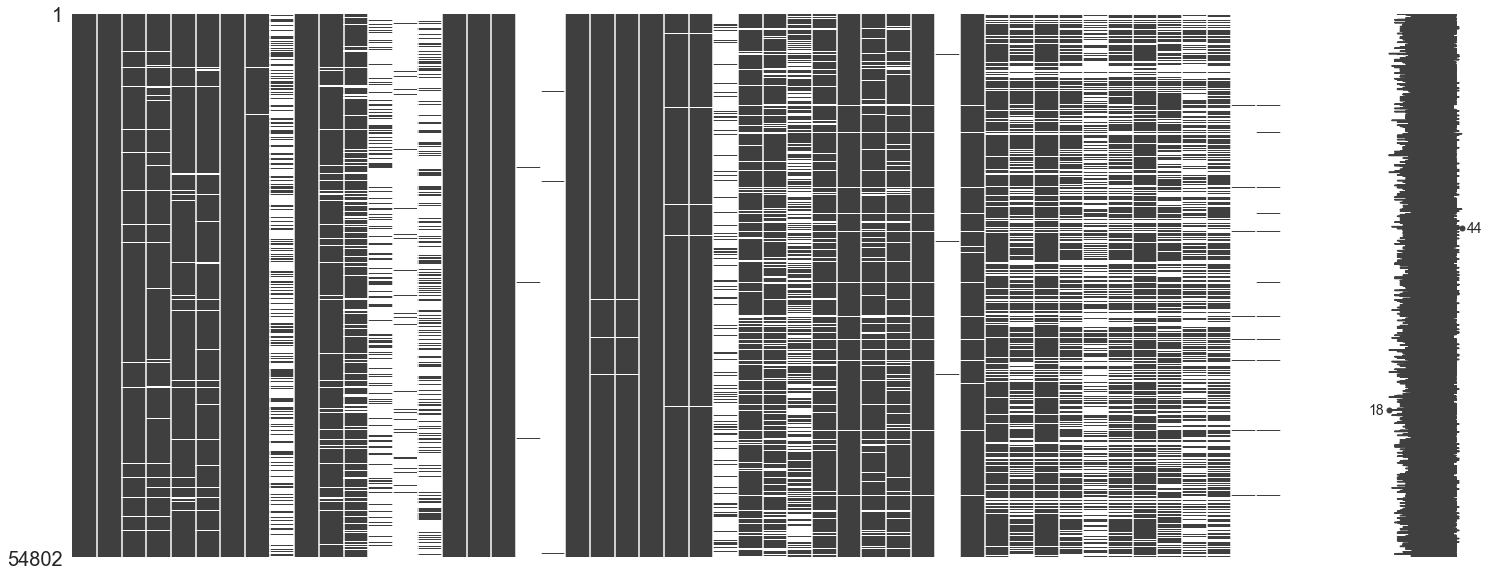

In [18]:
# checking if any pattern exists in newly transformed NAN values
msno.matrix(train)

In [19]:
print('\033[1m', 'All 50 columns', '\033[0m')
print('\033[1m', 'These', sum(train.isnull().mean().round(5) > 0.5),
      'columns have > 50% missing values', '\033[0m')
print(train.columns[train.isnull().mean().round(5) > 0.5].tolist())
print('')
raw_null_above50 = train[train.columns[train.isnull().mean().round(5) > 0.5].tolist()]
print(raw_null_above50.isnull().mean().round(5))
print('')
# Subset the data to include the columns only with nulls in the output
train_with_null = train[train.columns[train.isnull().any()].tolist()]
print('\033[1m', 'These', len(train_with_null.columns),
      'columns have any missing values', '\033[0m')
train_with_null.isnull().mean().round(5)

 All 50 columns 
 These 14 columns have > 50% missing values 
['LANE_CNT', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DOORING_I', 'WORK_ZONE_I', 'NUM_PASSENGERS', 'EXCEED_SPEED_LIMIT_I', 'SAFETY_EQUIPMENT', 'DRIVER_VISION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'BAC_RESULT VALUE', 'CELL_PHONE_USE']

LANE_CNT                  0.67016
INTERSECTION_RELATED_I    0.75691
NOT_RIGHT_OF_WAY_I        0.95883
HIT_AND_RUN_I             0.70238
DOORING_I                 0.99662
WORK_ZONE_I               0.99443
NUM_PASSENGERS            0.84501
EXCEED_SPEED_LIMIT_I      0.99715
SAFETY_EQUIPMENT          0.54288
DRIVER_VISION             0.50527
PEDPEDAL_ACTION           0.97907
PEDPEDAL_VISIBILITY       0.97597
BAC_RESULT VALUE          0.99807
CELL_PHONE_USE            0.99896
dtype: float64

 These 42 columns have any missing values 


TRAFFIC_CONTROL_DEVICE    0.02909
DEVICE_CONDITION          0.05237
WEATHER_CONDITION         0.03834
LIGHTING_CONDITION        0.03212
TRAFFICWAY_TYPE           0.00878
LANE_CNT                  0.67016
ROADWAY_SURFACE_COND      0.06027
ROAD_DEFECT               0.13824
INTERSECTION_RELATED_I    0.75691
NOT_RIGHT_OF_WAY_I        0.95883
HIT_AND_RUN_I             0.70238
DOORING_I                 0.99662
WORK_ZONE_I               0.99443
MOST_SEVERE_INJURY        0.00210
INJURIES_TOTAL            0.00208
LATITUDE                  0.00553
LONGITUDE                 0.00553
NUM_PASSENGERS            0.84501
LIC_PLATE_STATE           0.10591
VEHICLE_YEAR              0.18196
VEHICLE_DEFECT            0.42796
VEHICLE_TYPE              0.11520
VEHICLE_USE               0.02688
TRAVEL_DIRECTION          0.09691
MANEUVER                  0.09945
OCCUPANT_CNT              0.02688
EXCEED_SPEED_LIMIT_I      0.99715
FIRST_CONTACT_POINT       0.03465
PERSON_TYPE               0.13861
CITY          

In [20]:
# Filing NaN values after multiple tests

train.fillna({
    'TRAFFIC_CONTROL_DEVICE': 'NO CONTROLS',
    'DEVICE_CONDITION': 'NO CONTROLS',
    'WEATHER_CONDITION': 'CLEAR',
    'LIGHTING_CONDITION': 'DAYLIGHT',
    'TRAFFICWAY_TYPE': 'NOT DIVIDED',
    'ROADWAY_SURFACE_COND': 'NO DEFECTS',
    'ROAD_DEFECT': 'CLEAR',
    'INTERSECTION_RELATED_I': 'N',
    
    'NOT_RIGHT_OF_WAY_I': 'N',
    'HIT_AND_RUN_I': 'N',
    'DOORING_I': 'N',
    'WORK_ZONE_I': 'N',
    'NUM_PASSENGERS': 0,
    'LIC_PLATE_STATE': 'IL',
    'VEHICLE_DEFECT': 'UNABLE TO DETERMINE',
    'VEHICLE_TYPE': 'OTHER',
    
    'VEHICLE_USE': 'OTHER',
    'TRAVEL_DIRECTION': 'N',
    'MANEUVER': 'OTHER',
    'OCCUPANT_CNT': 0,
    'EXCEED_SPEED_LIMIT_I': 'N',
    'FIRST_CONTACT_POINT': 'OTHER',
    'PERSON_TYPE': 'UNABLE TO DETERMINE',
    'CITY': 'OTHER',
    
    'SEX': 'UNABLE TO DETERMINE',
    'AIRBAG_DEPLOYED': 'UNABLE TO DETERMINE',
    'EJECTION': 'UNABLE TO DETERMINE',
    'DRIVER_ACTION': 'OTHER',
    'DRIVER_VISION': 'OTHER',
    'PHYSICAL_CONDITION': 'UNABLE TO DETERMINE',
    'PEDPEDAL_ACTION': 'UNABLE TO DETERMINE',
    'PEDPEDAL_VISIBILITY': 'UNABLE TO DETERMINE',
    
    'CELL_PHONE_USE': 'UNABLE TO DETERMINE',
    'SAFETY_EQUIPMENT': 'UNABLE TO DETERMINE',
    'BAC_RESULT VALUE': 0
}, inplace=True)

#### Replace with frequency (mode):
“LANE_CNT”: 30,763 missing data. Replace them with mode “2”

In [21]:
train['LANE_CNT'].fillna("2",inplace=True)

#### Drop the missing row


In [22]:
drop_rows = ['INJURIES_TOTAL', 'LATITUDE','MOST_SEVERE_INJURY']
train.dropna(how='any', subset=drop_rows, inplace = True)
train.isnull().sum()

CRASH_DATE                     0
POSTED_SPEED_LIMIT             0
TRAFFIC_CONTROL_DEVICE         0
DEVICE_CONDITION               0
WEATHER_CONDITION              0
LIGHTING_CONDITION             0
FIRST_CRASH_TYPE               0
TRAFFICWAY_TYPE                0
LANE_CNT                       0
ALIGNMENT                      0
ROADWAY_SURFACE_COND           0
ROAD_DEFECT                    0
INTERSECTION_RELATED_I         0
NOT_RIGHT_OF_WAY_I             0
HIT_AND_RUN_I                  0
PRIM_CONTRIBUTORY_CAUSE        0
SEC_CONTRIBUTORY_CAUSE         0
STREET_DIRECTION               0
DOORING_I                      0
WORK_ZONE_I                    0
NUM_UNITS                      0
MOST_SEVERE_INJURY             0
INJURIES_TOTAL                 0
CRASH_HOUR                     0
LATITUDE                       0
LONGITUDE                      0
NUM_PASSENGERS                 0
LIC_PLATE_STATE                0
VEHICLE_YEAR                9920
VEHICLE_DEFECT                 0
VEHICLE_TY

# Handling Outliers 

##  Categorical Features

Example 1: A, B, C, X.

Example 2: Apple, Orange, Pear or Blueberry, Raspberry, Strawberry, Grape.

"*The fact is **no outlier** exists in the examples above, for an outlier to exist there must be **a measure of distance**. This is intrinsic to numeric data types because there is a Euclidean distance between numbers.*"

**Categorical Outliers don’t exist without a context.**

> "*Techniques like **string indexing** or **one-hot encoding** on a categorical value to convert it from a string value to a numeric value and then use k-means clustering to find outliers.*"

> "*the numeric vector assigned to the String value during the one hot encoding practice still lacks **the domain context**. It does satisfy the input constraint of the k-means model and the model will produce an output. However the output will not select the appropriate outlier, as the input **was not truly valid**.*"

> "*There is an alternative. **K-modes** is designed to handle categorical values without the need for String Indexing or One Hot Encoding.*"

##  Numerical Features

**`LANE_CNT`**

**Outlier Identification**

- 3 rows of 9
- 13 rows of 10
- 1 row of 11
- 4 rows of 12
- 2 rows of 99

According to Chicago's roadway, 6 should be a maximum number for lanes

**Decision** to replace outlier with 6 lanes

In [23]:
train['LANE_CNT']=pd.to_numeric(train['LANE_CNT'])
train['VEHICLE_YEAR']=pd.to_numeric(train['VEHICLE_YEAR'])
train['NUM_UNITS']=pd.to_numeric(train['NUM_UNITS'])
train["POSTED_SPEED_LIMIT"]=pd.to_numeric(train["POSTED_SPEED_LIMIT"])
train["AGE"]=pd.to_numeric(train["AGE"])

In [24]:
# Change all rows with value greater than 6 to 6
train.loc[(train['LANE_CNT'] > 6),'LANE_CNT'] = 6
train.loc[(train['LANE_CNT'] == 0),'LANE_CNT'] = 1
train['LANE_CNT'].value_counts()

2    44921
4     4408
1     3513
3      769
6      575
5      202
Name: LANE_CNT, dtype: int64

# Feature Engineering

##  Target Feature Engineering

Pick **`INJURIES_TOTAL`** as a numerical target and/or encode **`INJURY`** as a categorical target.

- `INJURY`: Total persons sustaining **fatal, incapacitating, non-incapacitating** as determined by the reporting officer.

13% Injuries, 87% Non-injuries

Removing NAs from INJURIES_TOTAL below

In [25]:
train["MOST_SEVERE_INJURY"].unique()

array(['NO INDICATION OF INJURY', 'NONINCAPACITATING INJURY',
       'INCAPACITATING INJURY', 'REPORTED, NOT EVIDENT', 'FATAL'],
      dtype=object)

In [26]:
def injury(x): 
    if any(s in x for s in ["FATAL","NONINCAPACITATING INJURY","INCAPACITATING INJURY"]):
        return "INJURED"
    else:
        return "NOT INJURED"
    
# replacing NA values with OTHER
train["INJURY"] = train["MOST_SEVERE_INJURY"].apply(lambda x: injury(x))
#train.drop("MOST_SEVERE_INJURY", axis=1, inplace=True)

In [27]:
def fatalities(x): 
    if any(s in x for s in ["FATAL"]):
        return "FATAL"
    else:
        return "NOT FATAL"
    
# replacing NA values with OTHER
train["FATALITIES"] = train["MOST_SEVERE_INJURY"].apply(lambda x: fatalities(x))
train.drop("MOST_SEVERE_INJURY", axis=1, inplace=True)

In [28]:
train["INJURY"].value_counts()

NOT INJURED    48496
INJURED         5892
Name: INJURY, dtype: int64

In [29]:
train["FATALITIES"].value_counts()

NOT FATAL    54324
FATAL           64
Name: FATALITIES, dtype: int64

##  Other Feature Engineering / Adaptation

### CONTACT_POINT

Reduced # of layers in `FIRST_CONTACT_POINT` to:
- FRONT
- SIDE
- READ
- OTHER

In [30]:
def contact_point(x):
    if "FRONT" in x:
        return "FRONT"
    elif "SIDE" in x:
        return "SIDE"
    elif "REAR" in x:
        return "REAR"
    else:
        return "OTHER"
    
# replacing NA values with OTHER
train["FIRST_CONTACT_POINT"] = train["FIRST_CONTACT_POINT"].apply(lambda x: contact_point(x))

### MANEUVER, VEHICLE_YEAR, POSTED_SPEED_LIMIT

Reduced # of layers in `MANEUVER` to:
- UNKNOWN/NA
- TURN
- LANE
- OTHER


In [31]:
# merging same type of Maneuver in one
train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "TURN" if "TURN" in x else("LANE" if any(s in x for s in ["LANE","OVER","ENTER"]) else x))
train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "OTHER" if all(s not in x for s in ["AHEAD","TURN","UNKNOWN","LANE","BACKING"]) else x)

# converting VEHICLE_YEAR into new category of OLD or NEW
#train["VEHICLE_YEAR"]= train["VEHICLE_YEAR"].apply(lambda x: "UNKNOWN" if pd.isnull(x) else ("OLD (<2010)" if int(x)<2010 else "NEW"))

# converting POSTED_SPEED_LIMIT into new category of LOW SPEED or HIGH SPEED
#train["POSTED_SPEED_LIMIT"]=train["POSTED_SPEED_LIMIT"].apply(lambda x: "LOW_SPEED" if int(x)<=30 else "HIGH_SPEED")

### SAFETY_EQUIPMENT, AIRBAG_DEPLOYED

Reduced # of layers in `SAFETY_EQUIPMENT` to:
- USED SAFETY EQUIPMENT
- DID NOT USE SAFETY EQUIPMENT

Reduced # of layers in `AIRBAG_DEPLOYED` to:
- DEPLOYED
- NOT DEPLOYED

In [32]:
# grouping the SAFETY_EQUIPMENT used as SAFE and UNSAFE
def equip_used(x):
    if ("USED" in x) or ("HELMET" in x) or ("NONE PRESENT" in x):
        if any(s in x for s in ["NOT","IMPROPER","NONE PRESENT"]):
            return "DID NOT USE SAFETY EQUIP"
        else:
            return "USED SAFETY EQUIP"
    else:
        return x

train["SAFETY_EQUIPMENT"]= train["SAFETY_EQUIPMENT"].apply(lambda x: equip_used(x))


# grouping the AIRBAG_DEPLOYED used as DEPLOYED and NOT DEPLOYED
def airbag(x):
    if ("DEPLOY" in x) and ("UNKNOWN" not in x):
        if "NOT" in x:
            return "NOT DEPLOYED"
        else:
            return "DEPLOYED"
    else:
        return x
 
train["AIRBAG_DEPLOYED"]= train["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))

### CRASH_HOUR

Transform the crash hour to 4 categories:
- Early morning
- Morning
- Afternoon
- Night

In [33]:
def crash_hour(x):
    if  2 <= x < 8:
        return "Early_morning"
    elif 8 <= x < 12:
        return "Morning"
    elif 12 <= x < 18:
        return "Afternoon"
    else:
        return "Night"
    
# replacing NA values with OTHER
train["CRASH_HOUR"] = train["CRASH_HOUR"].apply(lambda x: crash_hour(int(x)))

### TRAFFIC_CONTROL_DEVICE

Transform the signs
- 'TRAFFIC SIGNAL', 'STOP SIGN/FLASHER', 'LANE USE MARKING', 'YIELD', 'DELINEATORS', 
'OTHER REG. SIGN', 'OTHER WARNING SIGN', 'POLICE/FLAGMAN', 'RAILROAD CROSSING GATE', 
'OTHER RAILROAD CROSSING', 'FLASHING CONTROL SIGNAL', 'PEDESTRIAN CROSSING SIGN',
'NO PASSING', 'SCHOOL ZONE', 'BICYCLE CROSSING SIGN' as `SIGN`
    
- 'NO CONTROLS','UNKNOWN', 'OTHER' as `NO_SIGN`

In [34]:
def traffic_control(x):
    if ("NO CONTROLS" in x) or ("UNKNOWN" in x) or ("OTHER" in x):
        return "NO_SIGN"
    else:
        return "SIGN"

train["TRAFFIC_CONTROL_DEVICE"]= train["TRAFFIC_CONTROL_DEVICE"].apply(lambda x: traffic_control(x))

### TRAFFICWAY_TYPE

In [35]:
def traffic_way(x):
    if ("NOT" in x) or ("ONE-WAY" in x):
        return "NOT_DIVIDED"
    else:
        return "DIVIDED"

train["TRAFFICWAY_TYPE"]= train["TRAFFICWAY_TYPE"].apply(lambda x: traffic_way(x))

### LOCATION

In [36]:
def location(x1,x2):
    if (41.84 <= float(x1) <= 41.9100064) and (-87.7421459 <= float(x2) <= -87.50):
        return "Downtown"
    else:
        return "Not Downtown"

#df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)
train["Location"] = train.apply(lambda x: location(x["LATITUDE"],x["LONGITUDE"]), axis=1)

In [37]:
train["Location"].value_counts()

Not Downtown    39902
Downtown        14486
Name: Location, dtype: int64

### PRIM and SEC cause 

In [38]:
#dict_prim = {'DISREGARDING TRAFFIC SIGNALS' : 'IMPROPER ACTION BY THE DRIVER', 'IMPROPER OVERTAKING/PASSING' : 'IMPROPER ACTION BY THE DRIVER',
#            'ROAD CONSTRUCTION/MAINTENANCE' : 'EXTERNAL FORESEEABLE', 'nan' : np.nan, 'IMPROPER TURNING/NO SIGNAL' : 'IMPROPER ACTION BY THE DRIVER',
#            'FOLLOWING TOO CLOSELY' : 'IMPROPER ACTION BY THE DRIVER', 'DISTRACTION - FROM INSIDE VEHICLE' : 'IMPROPER ACTION BY THE DRIVER',
#            'IMPROPER BACKING' : 'IMPROPER ACTION BY THE DRIVER', 'IMPROPER LANE USAGE': 'IMPROPER ACTION BY THE DRIVER',
#            'FAILING TO YIELD RIGHT-OF-WAY' : 'IMPROPER ACTION BY THE DRIVER', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE' : 'DRIVING QUALIFICATION',
#            'DISREGARDING STOP SIGN' : 'IMPROPER ACTION BY THE DRIVER', 'NOT APPLICABLE' : np.nan, 'FAILING TO REDUCE SPEED TO AVOID CRASH' : 'DRIVING QUALIFICATION',
#            'DISREGARDING ROAD MARKINGS' : 'EXTERNAL FORESEEABLE', 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER' : 'IMPROPER ACTION BY THE DRIVER',
#            'DISTRACTION - FROM OUTSIDE VEHICLE' : 'EXTERNAL UNFORSEEABLE', 'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST' : 'EXTERNAL UNFORSEEABLE',
#            'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)' : 'IMPROPER ACTION BY THE DRIVER',
#            'WEATHER' : 'EXTERNAL FORESEEABLE', 'DRIVING ON WRONG SIDE/WRONG WAY' : 'DRIVING QUALIFICATION', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)' : 'EXTERNAL UNFORSEEABLE',
#            'EXCEEDING AUTHORIZED SPEED LIMIT' : 'IMPROPER ACTION BY THE DRIVER', 'EXCEEDING SAFE SPEED FOR CONDITIONS': 'IMPROPER ACTION BY THE DRIVER',
#            'PHYSICAL CONDITION OF DRIVER' : 'DRIVING QUALIFICATION', 'DISREGARDING OTHER TRAFFIC SIGNS' : 'IMPROPER ACTION BY THE DRIVER',
#            'EQUIPMENT - VEHICLE CONDITION' : 'EXTERNAL FORESEEABLE', 'RELATED TO BUS STOP' : 'EXTERNAL FORESEEABLE', 'CELL PHONE USE OTHER THAN TEXTING' : 'IMPROPER ACTION BY THE DRIVER',
#            'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT' : 'IMPROPER ACTION BY THE DRIVER', 'PASSING STOPPED SCHOOL BUS' : 'IMPROPER ACTION BY THE DRIVER',
#            'ROAD ENGINEERING/SURFACE/MARKING DEFECTS' : 'EXTERNAL FORESEEABLE', 'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)' : 'IMPROPER ACTION BY THE DRIVER',
#            'TEXTING' : 'IMPROPER ACTION BY THE DRIVER', 'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)' : 'EXTERNAL FORESEEABLE',
#            'TURNING RIGHT ON RED' : 'IMPROPER ACTION BY THE DRIVER', 'DISREGARDING YIELD SIGN' : 'IMPROPER ACTION BY THE DRIVER',
#            'ANIMAL' : 'EXTERNAL UNFORSEEABLE', 'BICYCLE ADVANCING LEGALLY ON RED LIGHT' : 'EXTERNAL UNFORSEEABLE'}

In [39]:
#train['PRIM_CONTRIBUTORY_CAUSE'] = train["PRIM_CONTRIBUTORY_CAUSE"].map(dict_prim)

In [40]:
#dict_sec = {'FAILING TO YIELD RIGHT-OF-WAY' : 'IMPROPER ACTION BY THE DRIVER', 'nan' : np.nan, 'NOT APPLICABLE' : np.nan,
#           'DISTRACTION - FROM INSIDE VEHICLE' : 'EXTERNAL FORSEEABLE', 'IMPROPER OVERTAKING/PASSING' : 'IMPROPER ACTION BY THE DRIVER',
#           'FAILING TO REDUCE SPEED TO AVOID CRASH' : 'IMPROPER ACTION BY THE DRIVER', 'IMPROPER LANE USAGE' : 'IMPROPER ACTION BY THE DRIVER',
#           'EXCEEDING SAFE SPEED FOR CONDITIONS' : 'IMPROPER ACTION BY THE DRIVER', 'IMPROPER TURNING/NO SIGNAL' : 'IMPROPER ACTION BY THE DRIVER',
#           'FOLLOWING TOO CLOSELY' : 'DRIVING QUALIFICATION', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE' : 'DRIVING QUALIFICATION',
#           'WEATHER' : 'EXTERNAL FORSEEABLE', 'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER' : 'IMPROPER ACTION BY THE DRIVER',
#           'DISTRACTION - FROM OUTSIDE VEHICLE' : 'EXTERNAL UNFORSEEABLE', 'DISREGARDING STOP SIGN' : 'IMPROPER ACTION BY THE DRIVER',
#           'CELL PHONE USE OTHER THAN TEXTING' : 'IMPROPER ACTION BY THE DRIVER', 'PHYSICAL CONDITION OF DRIVER' : 'DRIVING QUALIFICATION',
#           'IMPROPER BACKING' : 'IMPROPER ACTION BY THE DRIVER', 'EXCEEDING AUTHORIZED SPEED LIMIT' : 'IMPROPER ACTION BY THE DRIVER',
#           'DISREGARDING TRAFFIC SIGNALS' : 'IMPROPER ACTION BY THE DRIVER', 'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)': 'IMPROPER ACTION BY THE DRIVER',
#           'DRIVING ON WRONG SIDE/WRONG WAY' : 'DRIVING QUALIFICATION', 'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)': 'IMPROPER ACTION BY THE DRIVER',
#           'ROAD CONSTRUCTION/MAINTENANCE' : 'EXTERNAL FORSEEABLE', 'EQUIPMENT - VEHICLE CONDITION' : 'EXTERNAL UNFORSEEABLE',
#           'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)' : 'EXTERNAL UNFORSEEABLE', 'TURNING RIGHT ON RED' : 'IMPROPER ACTION BY THE DRIVER',
#           'DISREGARDING ROAD MARKINGS' : 'IMPROPER ACTION BY THE DRIVER', 'DISREGARDING OTHER TRAFFIC SIGNS' : 'IMPROPER ACTION BY THE DRIVER',
#           'BICYCLE ADVANCING LEGALLY ON RED LIGHT' : 'EXTERNAL UNFORSEEABLE', 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS' : 'EXTERNAL UNFORSEEABLE',
#           'RELATED TO BUS STOP' : 'DRIVING QUALIFICATION', 'DISREGARDING YIELD SIGN' : 'IMPROPER ACTION BY THE DRIVER', 'OBSTRUCTED CROSSWALKS' : 'IMPROPER ACTION BY THE DRIVER',
#           'ANIMAL' : 'EXTERNAL UNFORSEEABLE', 'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)' : 'EXTERNAL FORSEEABLE',
#          'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST' : 'EXTERNAL UNFORSEEABLE', 'TEXTING' : 'IMPROPER ACTION BY THE DRIVER', 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT' : 'IMPROPER ACTION BY THE DRIVER',
#          'PASSING STOPPED SCHOOL BUS' : 'IMPROPER ACTION BY THE DRIVER'}


In [41]:
#train['SEC_CONTRIBUTORY_CAUSE'] = train["SEC_CONTRIBUTORY_CAUSE"].map(dict_sec)

### CAR AGE

In [42]:
train["VEHICLE_AGE"]=train["CRASH_DATE"].dt.year-train["VEHICLE_YEAR"]

In [43]:
train.loc[train["VEHICLE_AGE"]<0,"VEHICLE_AGE"]=0

In [44]:
train.drop("VEHICLE_YEAR",axis=1,inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54388 entries, 29244 to 15795
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CRASH_DATE               54388 non-null  datetime64[ns]
 1   POSTED_SPEED_LIMIT       54388 non-null  int64         
 2   TRAFFIC_CONTROL_DEVICE   54388 non-null  object        
 3   DEVICE_CONDITION         54388 non-null  object        
 4   WEATHER_CONDITION        54388 non-null  object        
 5   LIGHTING_CONDITION       54388 non-null  object        
 6   FIRST_CRASH_TYPE         54388 non-null  object        
 7   TRAFFICWAY_TYPE          54388 non-null  object        
 8   LANE_CNT                 54388 non-null  int64         
 9   ALIGNMENT                54388 non-null  object        
 10  ROADWAY_SURFACE_COND     54388 non-null  object        
 11  ROAD_DEFECT              54388 non-null  object        
 12  INTERSECTION_RELATED_I   543

# Modeling

## Random Forest -Classifier (All Post-Crash Categories)

In [46]:
## removing below columns
# drop_list=["LATITUDE","LONGITUDE","INJURIES_TOTAL","CRASH_DATE"]

# train_new_class = train.drop(drop_list, axis=1)

In [47]:
# # splitting the dataset into x_train and y_train
# X_train = train_new_class.drop(["INJURY"],axis=1).reset_index(drop=True)
# #y_train = train_new_class["INJURY"]

In [48]:
#X_train.isnull().sum()

In [49]:
# # performing one hot encoding on all the object features
# X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns, drop_first=True)

In [50]:
# y_train = train_new["INJURY"]
# y_train_new = (y_train == "INJURED")
# y_train_new=y_train_new.astype(int)

In [51]:
# #Create a Random Forest Classifier
# clf=RandomForestClassifier(n_estimators=100)

# #Train the model using the training sets y_pred=clf.predict(X_test)
# scores = cross_val_score(clf, X_train, y_train_new, cv=5)
# print('Accuracy', np.mean(scores), scores)

In [52]:
# recall = cross_val_score(clf, X_train, y_train_new, cv=5, scoring='recall')
# print('Recall', np.mean(recall), recall)
# precision = cross_val_score(clf, X_train, y_train_new, cv=5, scoring='precision')
# print('Precision', np.mean(precision), precision)
# f1 = cross_val_score(clf, X_train, y_train_new, cv=5, scoring='f1')
# print('F1', np.mean(f1), f1)

In [53]:
# #Create a Random Forest Classifier
# clf=RandomForestClassifier(n_estimators=100)
# clf.fit(X_train,y_train_new)
# print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

In [54]:
# feat_importances.nlargest(50)

## Random Forest - Regressor (All Post-Crash Categories)

In [55]:
# # removing below columns
# drop_list=["LATITUDE","LONGITUDE","INJURY","CRASH_DATE"]

# train_new_reg = train.drop(drop_list, axis=1)

In [56]:
# # splitting the dataset into x_train and y_train
# X_train = train_new_reg.drop(["INJURIES_TOTAL"],axis=1)
# y_train = train_new_reg["INJURIES_TOTAL"]

In [57]:
#X_train.info()

In [58]:
# # performing one hot encoding on all the object features
# X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns, drop_first=True)

In [59]:
# X_train.head()

In [60]:
#Create a Random Forest Classifier
#clf=RandomForestRegressor()

#Train the model using the training sets y_pred=clf.predict(X_test)
#scores = cross_val_score(clf, X_train, y_train, cv=5)
#print('mean_squared_error', np.mean(scores), scores)

In [61]:
# #Create a Random Forest Classifier
# clf=RandomForestRegressor()
# clf.fit(X_train,y_train)
# print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

In [62]:
# feat_importances.nlargest(50)

In [63]:
# train=pd.read_csv("Preprocessed_data.csv")

In [64]:
# train_new=train.copy()

# Sprint 4

**Today's Agenda**

- Experimentation for Model improvement
- Balancing technique
- Hyper parameter tuning
- Precision-Recall curve
- ROC Curve
- Evaluation of model on Test Dataset
- Take home messages based on most Important Contrbuting factors

## Random Forest -Classifier (INJURIES)

In [65]:
filter_list=["AGE","LANE_CNT","AIRBAG_DEPLOYED","PRIM_CONTRIBUTORY_CAUSE","POSTED_SPEED_LIMIT","NUM_UNITS","TRAFFICWAY_TYPE",  
             "SEC_CONTRIBUTORY_CAUSE","VEHICLE_AGE","FIRST_CRASH_TYPE","INJURY","LIGHTING_CONDITION","SEX"]

train_new = train[filter_list]

**Final Features**

- **AGE, LANE_CNT, AIRBAG_DEPLOYED, PRIM_CONTRIBUTORY_CAUSE**
- **POSTED_SPEED_LIMIT, NUM_UNITS, TRAFFICWAY_TYPE**
- **SEC_CONTRIBUTORY_CAUSE, VEHICLE_AGE, FIRST_CRASH_TYPE**
- **LIGHTING_CONDITION, SEX**



- **Dependent Feature - Injury (INJURED/NOT_INJURED)**

In [66]:
# splitting the dataset into x_train and y_train
X_train = train_new.drop(["INJURY"],axis=1)
y_train = train_new["INJURY"]

In [67]:
# performing one hot encoding on all the object features
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns)

In [68]:
dummies_to_drop = X_train.columns[X_train.columns.str.contains("UNABLE|UNKNOWN|NOT APPLICABLE|OTHER")]
X_train = X_train.loc[:, ~X_train.columns.isin(dummies_to_drop)]

In [69]:
#X_train.info()

In [70]:
#from sklearn.impute import KNNImputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(X_train),columns = X_train.columns)
X_train=df.copy()
X_train=np.round(X_train)

In [71]:
train.reset_index(drop=True,inplace=True)
train[["AGE","VEHICLE_AGE"]]=X_train[["AGE","VEHICLE_AGE"]]

In [72]:
y_train = train_new["INJURY"]
y_train_new = (y_train == "INJURED")
y_train_new=y_train_new.astype(int)
#Encode the y_train labels
#lb = preprocessing.LabelBinarizer()
#y_train=lb.fit_transform(y_train)

In [73]:
#y_train_new

In [74]:
#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
scores = cross_val_score(clf, X_train, y_train_new, cv=5)
print('Accuracy', np.mean(scores), scores)

Accuracy 0.913694201469192 [0.91560949 0.91184041 0.9134032  0.91293555 0.91468236]


In [75]:
# recall = cross_val_score(clf, X_train, y_train_new, cv=5, scoring='recall')
# print('Recall', np.mean(recall), recall)
# precision = cross_val_score(clf, X_train, y_train_new, cv=5, scoring='precision')
# print('Precision', np.mean(precision), precision)
# f1 = cross_val_score(clf, X_train, y_train_new, cv=5, scoring='f1')
# print('F1', np.mean(f1), f1)

In [76]:
# #Create a Random Forest Classifier
# clf=RandomForestClassifier(n_estimators=100)
# clf.fit(X_train,y_train_new)
# print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

In [77]:
#feat_importances.nlargest(50)

## Checking other models

In [78]:
def evaluate_model(model, X_, y_):
    score_cols = ['Metric','Accuracy','Precision', 'Recall', 'F1 Score', 'AUC']
    score_df = pd.DataFrame(columns=score_cols)
    
    model_name = model.__class__.__name__
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    auc_lst = []
    
    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    for train_index, test_index in cv.split(X_,y_):   
        X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
        y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
        
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        accuracy_lst.append(accuracy_score(y_test,prediction))
        precision_lst.append(precision_score(y_test,prediction))
        recall_lst.append(recall_score(y_test,prediction))
        f1_lst.append(f1_score(y_test,prediction))
        auc_lst.append(roc_auc_score(y_test, prediction))

    score_df.loc[0,'Metric'] = model_name
    score_df.loc[0,'Accuracy'] = '{0:0.3f}'.format(np.mean(accuracy_lst))
    score_df.loc[0,'Precision'] = '{0:0.3f}'.format(np.mean(precision_lst))
    score_df.loc[0,'Recall'] = '{0:0.3f}'.format(np.mean(recall_lst))
    score_df.loc[0,'F1 Score'] = '{0:0.3f}'.format(np.mean(f1_lst))
    score_df.loc[0,'AUC'] = '{0:0.3f}'.format(np.mean(auc_lst))
    return score_df

In [79]:
# logreg = LogisticRegression()
# logreg_noresampling = evaluate_model(logreg,X_train,y_train_new)

In [80]:
# rfc = RandomForestClassifier()
# rfc_noresampling = evaluate_model(rfc,X_train,y_train_new)

In [81]:
# xgb = XGBClassifier()
# xgb_noresampling=evaluate_model(xgb,X_train,y_train_new)

In [82]:
# no_result = pd.concat([logreg_noresampling,rfc_noresampling,xgb_noresampling], axis=0)
# no_result

## Undersampling

In [83]:
def evaluate_model_undersampling(model, X_, y_, resampling_rate):
    score_cols = ['Metric','Accuracy','Precision', 'Recall', 'F1 Score', 'AUC']
    score_df = pd.DataFrame(columns=score_cols)
    
    model_name = model.__class__.__name__
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    auc_lst = []
    
    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    for train_index, test_index in cv.split(X_,y_):        
        X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
        y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
        
        X_train = X_train.values
        X_test = X_test.values
        y_train = y_train.values
        y_test = y_test.values
        
        under = RandomUnderSampler(sampling_strategy=resampling_rate)
        X_under, y_under = under.fit_resample(X_train, y_train)
        count = Counter(y_under)
        print(count)
        
        steps = [('u', under),('model', model)]
        pipeline = Pipeline(steps=steps)
        pipeline.fit(X_train, y_train)
        
        prediction = model.predict(X_test)
        accuracy_lst.append(accuracy_score(y_test,prediction))
        precision_lst.append(precision_score(y_test,prediction))
        recall_lst.append(recall_score(y_test,prediction))
        f1_lst.append(f1_score(y_test,prediction))
        auc_lst.append(roc_auc_score(y_test, prediction))
    score_df.loc[0,'Metric'] = model_name + ' ' + str(resampling_rate*100) + '%'
    score_df.loc[0,'Accuracy'] = '{0:0.3f}'.format(np.mean(accuracy_lst))
    score_df.loc[0,'Precision'] = '{0:0.3f}'.format(np.mean(precision_lst))
    score_df.loc[0,'Recall'] = '{0:0.3f}'.format(np.mean(recall_lst))
    score_df.loc[0,'F1 Score'] = '{0:0.3f}'.format(np.mean(f1_lst))
    score_df.loc[0,'AUC'] = '{0:0.3f}'.format(np.mean(auc_lst))
    return score_df

### Logistic Regression with undersampling

In [84]:
# logreg = LogisticRegression()
# logreg_under_maj = evaluate_model_undersampling(logreg,X_train,y_train_new,'majority')

In [85]:
# logreg = LogisticRegression()
# logreg_under_50 = evaluate_model_undersampling(logreg,X_train,y_train_new,0.5)

### Support Vector with undersampling

In [86]:
# svm = SVC()
# svm_under_maj =evaluate_model_undersampling(svm,X_train,y_train_new,'majority')

In [87]:
# svm = SVC()
# svm_under_50  = evaluate_model_undersampling(svm,X_train,y_train_new,0.5)

### Random Forest with undersampling

In [88]:
# rfc = RandomForestClassifier()
# rfc_under_maj = evaluate_model_undersampling(rfc,X_train,y_train_new,'majority')

In [89]:
# rfc = RandomForestClassifier()
# rfc_under_50 = evaluate_model_undersampling(rfc,X_train,y_train_new,0.5)

### XGBoost with undersampling

In [90]:
# xgb = XGBClassifier()
# xgb_under_maj = evaluate_model_undersampling(xgb,X_train,y_train_new,'majority')

In [91]:
# xgb = XGBClassifier()
# xgb_under_50 = evaluate_model_undersampling(xgb,X_train,y_train_new,0.5)

### Results

In [92]:
# under_result = pd.concat([logreg_under_maj,logreg_under_50,
#                          svm_under_maj,svm_under_50,
#                          rfc_under_maj,rfc_under_50,
#                          xgb_under_maj,xgb_under_50], axis=0)
# under_result

## Oversampling - RandomOverSampling

In [93]:
def evaluate_model_oversampling_random(model, X_, y_, resampling_rate):
    score_cols = ['Metric','Accuracy','Precision', 'Recall', 'F1 Score', 'AUC']
    score_df = pd.DataFrame(columns=score_cols)
    
    model_name = model.__class__.__name__
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    auc_lst = []
    
    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    for train_index, test_index in cv.split(X_,y_):        
        X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
        y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
        
        X_train = X_train.values
        X_test = X_test.values
        y_train = y_train.values
        y_test = y_test.values
        
        under = RandomOverSampler(sampling_strategy=resampling_rate)
        X_under, y_under = under.fit_resample(X_train, y_train)
        count = Counter(y_under)
        print(count)
        
        steps = [('u', under),('model', model)]
        pipeline = Pipeline(steps=steps)
        pipeline.fit(X_train, y_train)
        
        prediction = model.predict(X_test)
        accuracy_lst.append(accuracy_score(y_test,prediction))
        precision_lst.append(precision_score(y_test,prediction))
        recall_lst.append(recall_score(y_test,prediction))
        f1_lst.append(f1_score(y_test,prediction))
        auc_lst.append(roc_auc_score(y_test, prediction))
    score_df.loc[0,'Metric'] = model_name + ' ' + str(resampling_rate*100) + '%'
    score_df.loc[0,'Accuracy'] = '{0:0.3f}'.format(np.mean(accuracy_lst))
    score_df.loc[0,'Precision'] = '{0:0.3f}'.format(np.mean(precision_lst))
    score_df.loc[0,'Recall'] = '{0:0.3f}'.format(np.mean(recall_lst))
    score_df.loc[0,'F1 Score'] = '{0:0.3f}'.format(np.mean(f1_lst))
    score_df.loc[0,'AUC'] = '{0:0.3f}'.format(np.mean(auc_lst))
    return score_df

### Logistic Regression with oversampling

In [94]:
# logreg = LogisticRegression()
# logreg_over_maj = evaluate_model_oversampling_random(logreg,X_train,y_train_new,'minority')

In [95]:
# logreg = LogisticRegression()
# logreg_over_50 = evaluate_model_oversampling_random(logreg,X_train,y_train_new,0.5)

### Random Forest with oversampling

In [96]:
# rfc = RandomForestClassifier()
# rfc_over_maj = evaluate_model_oversampling_random(rfc,X_train,y_train_new,'minority')

In [97]:
# rfc = RandomForestClassifier()
# rfc_under_50 = evaluate_model_oversampling_random(rfc,X_train,y_train_new,0.5)

### XGBoost with oversampling

In [98]:
# xgb = XGBClassifier()
# xgb_over_maj = evaluate_model_oversampling_random(xgb,X_train,y_train_new,'minority')

In [99]:
# xgb = XGBClassifier()
# xgb_over_50 = evaluate_model_oversampling_random(xgb,X_train,y_train_new,0.5)

### Results

In [100]:
# over_rand_result = pd.concat([logreg_over_maj,logreg_over_50,
#                          rfc_over_maj,rfc_under_50,
#                          xgb_over_maj,xgb_over_50], axis=0)
# over_rand_result

## Oversampling - SMOTE

In [101]:
def evaluate_model_oversampling(model, X_, y_, resampling_rate):
    score_cols = ['Metric','Accuracy','Precision', 'Recall', 'F1 Score', 'AUC']
    score_df = pd.DataFrame(columns=score_cols)
    
    model_name = model.__class__.__name__
    accuracy_lst = []
    precision_lst = []
    recall_lst = []
    f1_lst = []
    auc_lst = []
    
    cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
    for train_index, test_index in cv.split(X_,y_):        
        X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
        y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
        
        X_train = X_train.values
        X_test = X_test.values
        y_train = y_train.values
        y_test = y_test.values
        
        over = SMOTE(sampling_strategy=resampling_rate)
        steps = [('o', over), ('model', model)]
        pipeline = Pipeline(steps=steps)
        pipeline.fit(X_train, y_train)
        
        prediction = model.predict(X_test)
        accuracy_lst.append(accuracy_score(y_test,prediction))
        precision_lst.append(precision_score(y_test,prediction))
        recall_lst.append(recall_score(y_test,prediction))
        f1_lst.append(f1_score(y_test,prediction))
        auc_lst.append(roc_auc_score(y_test, prediction))
    score_df.loc[0,'Metric'] = model_name + ' ' + str(resampling_rate*100) + '%'
    score_df.loc[0,'Accuracy'] = '{0:0.3f}'.format(np.mean(accuracy_lst))
    score_df.loc[0,'Precision'] = '{0:0.3f}'.format(np.mean(precision_lst))
    score_df.loc[0,'Recall'] = '{0:0.3f}'.format(np.mean(recall_lst))
    score_df.loc[0,'F1 Score'] = '{0:0.3f}'.format(np.mean(f1_lst))
    score_df.loc[0,'AUC'] = '{0:0.3f}'.format(np.mean(auc_lst))
    return score_df

In [102]:
# logreg = LogisticRegression()
# logreg_over_maj = evaluate_model_oversampling(logreg,X_train,y_train_new,'minority')

In [103]:
# logreg = LogisticRegression()
# logreg_over_50 = evaluate_model_oversampling(logreg,X_train,y_train_new,0.5)

In [104]:
# rfc = RandomForestClassifier()
# rfc_over_maj = evaluate_model_oversampling(rfc,X_train,y_train_new,'minority')

In [105]:
# rfc = RandomForestClassifier()
# rfc_over_50 = evaluate_model_oversampling(rfc,X_train,y_train_new,0.5)

In [106]:
# xgb = XGBClassifier()
# xgb_over_maj = evaluate_model_oversampling(xgb,X_train,y_train_new,'minority')

In [107]:
# xgb = XGBClassifier()
# xgb_over_50 = evaluate_model_oversampling(xgb,X_train,y_train_new,0.5)

### Results

In [108]:
# over_smote_result = pd.concat([logreg_over_maj,logreg_over_50,
#                          rfc_over_maj,rfc_over_50,
#                          xgb_over_maj,xgb_over_50], axis=0)
# over_smote_result

## Undersampling after Scaling

- **Scaled AGE, LANE_CNT, POSTED_SPEED_LIMIT, NUM_UNITS, VEHICLE_AGE**

In [109]:
# std_scaler = StandardScaler()

# scaled_AGE = std_scaler.fit_transform(X_train['AGE'].values.reshape(-1,1))
# scaled_LANE_CNT = std_scaler.fit_transform(X_train['LANE_CNT'].values.reshape(-1,1))
# scaled_POSTED_SPEED_LIMIT = std_scaler.fit_transform(X_train['POSTED_SPEED_LIMIT'].values.reshape(-1,1))
# scaled_NUM_UNITS = std_scaler.fit_transform(X_train['NUM_UNITS'].values.reshape(-1,1))
# scaled_VEHICLE_AGE = std_scaler.fit_transform(X_train['VEHICLE_AGE'].values.reshape(-1,1))

# X_train_scaled = X_train.copy()
# X_train_scaled.drop(['AGE','LANE_CNT','POSTED_SPEED_LIMIT','NUM_UNITS','VEHICLE_AGE'], axis=1, inplace=True)

# X_train_scaled.insert(0,'scaled_AGE',scaled_AGE)
# X_train_scaled.insert(1,'scaled_LANE_CNT',scaled_LANE_CNT)
# X_train_scaled.insert(2,'scaled_POSTED_SPEED_LIMIT',scaled_POSTED_SPEED_LIMIT)
# X_train_scaled.insert(3,'scaled_NUM_UNITS',scaled_NUM_UNITS)
# X_train_scaled.insert(4,'scaled_VEHICLE_AGE',scaled_VEHICLE_AGE)
# X_train_scaled.head()

### Logistic Regression with Undersampling - Scaled data

In [110]:
# logreg = LogisticRegression()
# logreg_under_maj = evaluate_model_undersampling(logreg,X_train_scaled,y_train_new,'majority')

In [111]:
# logreg = LogisticRegression()
# logreg_under_50 = evaluate_model_undersampling(logreg,X_train_scaled,y_train_new,0.5)

### Support Vector Classifier with Undersampling - Scaled data

In [112]:
# svm = SVC()
# svm_under_maj =evaluate_model_undersampling(svm,X_train_scaled,y_train_new,'majority')

In [113]:
# svm = SVC()
# svm_under_50  = evaluate_model_undersampling(svm,X_train_scaled,y_train_new,0.5)

### Random Forest with Undersampling - Scaled data

In [114]:
# rfc = RandomForestClassifier()
# rfc_under_maj = evaluate_model_undersampling(rfc,X_train_scaled,y_train_new,'majority')

In [115]:
# rfc = RandomForestClassifier()
# rfc_under_50 = evaluate_model_undersampling(rfc,X_train_scaled,y_train_new,0.5)

### XGBoost with Undersampling - Scaled data

In [116]:
# xgb = XGBClassifier()
# xgb_under_maj = evaluate_model_undersampling(xgb,X_train_scaled,y_train_new,'majority')

In [117]:
# xgb = XGBClassifier()
# xgb_under_50 = evaluate_model_undersampling(xgb,X_train_scaled,y_train_new,0.5)

### Results

In [118]:
# under_post_scale_result = pd.concat([logreg_under_maj,logreg_under_50,
#                          svm_under_maj,svm_under_50,
#                          rfc_under_maj,rfc_under_50,
#                          xgb_under_maj,xgb_under_50], axis=0)
# under_post_scale_result

In [119]:
# under_post_scale_result = pd.concat([logreg_under_maj,logreg_under_50,
#                          svm_under_maj,svm_under_50,
#                          rfc_under_maj,rfc_under_50,
#                          xgb_under_maj,xgb_under_50], axis=0)
# under_post_scale_result

# Random Forest Classifier - HyperParameter Tuning and ROC Curve

In [120]:
# Undersampling the data first after scaling of data
under = RandomUnderSampler(sampling_strategy=1)
X_under, y_under = under.fit_resample(X_train, y_train_new)
#X_under, y_under = under.fit_resample(X_train_scaled, y_train_new)
count = Counter(y_under)
print(count)

Counter({0: 5892, 1: 5892})


In [ ]:
# # Oversampling the data first after scaling of data
# over = RandomOverSampler(sampling_strategy=0.5)
# X_over, y_over = over.fit_resample(X_train, y_train_new)
# #X_under, y_under = under.fit_resample(X_train_scaled, y_train_new)
# count = Counter(y_over)
# print(count)

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [122]:
# # Create a Random Forest Classifier
# rf = RandomForestClassifier()

# # Hyperparameter Optimization
# parameters = {'n_estimators': [100, 300, 500, 800, 1000], 
#               'max_features': ['log2', 'sqrt','auto'], 
#               'criterion': ['entropy', 'gini'],
#               'max_depth': [5, 8, 10, 13], 
#               'min_samples_split': [2, 5, 10, 15],
#               'min_samples_leaf': [5, 8, 15]
#              }

# cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
# random_search = RandomizedSearchCV(rf, parameters, cv = cv, verbose = 1, n_jobs = -1, scoring='recall')
# random_search.fit(X_under, y_under)

In [123]:
# # Create a Random Forest Classifier
# rf = RandomForestClassifier()

# # Hyperparameter Optimization
# parameters = {'n_estimators': [100, 300, 500, 800, 1000], 
#               'max_features': ['log2', 'sqrt','auto'], 
#               'criterion': ['entropy', 'gini'],
#               'max_depth': [5, 8, 10, 13], 
#               'min_samples_split': [2, 5, 10, 15],
#               'min_samples_leaf': [5, 8, 15]
#              }

# cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
# random_search = RandomizedSearchCV(rf, parameters, n_iter=30,cv = cv, verbose = 1, n_jobs = -1, scoring='recall')
# random_search.fit(X_over, y_over)

In [124]:
#random_search.best_params_

In [125]:
#random_search.best_score_

In [126]:
random_final = RandomForestClassifier(n_estimators=1000, min_samples_split=15, min_samples_leaf=5,
                                      max_features='log2', max_depth=13, criterion='entropy')

In [127]:
cv = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [128]:
recall = cross_val_score(random_final, X_under, y_under, cv=cv, scoring='recall', n_jobs=-1)
print('Recall', np.mean(recall), recall)
precision = cross_val_score(random_final, X_under, y_under, cv=cv, scoring='precision', n_jobs=-1)
print('Precision', np.mean(precision), precision)
f1_score = cross_val_score(random_final, X_under, y_under, cv=cv, scoring='f1', n_jobs=-1)
print('F1 Score', np.mean(f1_score), f1_score)
ROC_score = cross_val_score(random_final, X_under, y_under, cv=cv, scoring='roc_auc', n_jobs=-1)
print('ROC AUC', np.mean(ROC_score), ROC_score)

Recall 0.6902569153738817 [0.71561969 0.67996604 0.68108567 0.70568278 0.66893039]
Precision 0.8048073285514586 [0.83070866 0.79097154 0.79861111 0.79765396 0.80609137]
F1 Score 0.7432884454375499 [0.76697248 0.73584051 0.72927164 0.74727273 0.73708487]
ROC AUC 0.8458852348780453 [0.86178576 0.83373654 0.84560561 0.8387266  0.84957166]


In [129]:
# recall = cross_val_score(random_final, X_over, y_over, cv=cv, scoring='recall', n_jobs=-1)
# print('Recall', np.mean(recall), recall)
# precision = cross_val_score(random_final,  X_over, y_over, cv=cv, scoring='precision', n_jobs=-1)
# print('Precision', np.mean(precision), precision)
# f1_score = cross_val_score(random_final,  X_over, y_over, cv=cv, scoring='f1', n_jobs=-1)
# print('F1 Score', np.mean(f1_score), f1_score)
# ROC_score = cross_val_score(random_final,  X_over, y_over, cv=cv, scoring='roc_auc', n_jobs=-1)
# print('ROC AUC', np.mean(ROC_score), ROC_score)

**With Scaling and UnderSampling**
- **n_estimators=800, min_samples_split=15, min_samples_leaf=8, max_features='log2', max_depth=13, criterion='gini'**


- Recall 0.6804159088519952 [0.70033956 0.67996604 0.67430025 0.67599661 0.67147708]
- Precision 0.8146099267117444 [0.83130081 0.7957958  0.80040323 0.82479508 0.82075472]
- F1 Score 0.739560393989348 [0.76033058 0.73143905 0.73018781 0.74101727 0.73482726

**With Scaling and UnderSampling with changes in hyperparameters**
- **n_estimators=800, min_samples_split=2, min_samples_leaf=5, max_features='sqrt', max_depth=13, criterion='entropy'**


- Recall 0.6833025887381179 [0.71222411 0.66977929 0.67345208 0.67430025 0.68675722]
- Precision 0.8113637651590022 [0.81152344 0.8221303  0.79919679 0.81619938 0.80776892]
- F1 Score 0.7414320065691127 [0.75555556 0.73689183 0.73403767 0.73595506 0.74471993]

**Without Scaling and with UnderSampling**
- **n_estimators=1000, min_samples_split=15, min_samples_leaf=5,max_features='log2', max_depth=13, criterion='entropy'**


- Recall 0.6890733564601811 [0.72495756 0.6893039  0.68278202 0.67514843 0.67317487]
- Precision 0.7946069184605669 [0.79699248 0.79745597 0.80693069 0.77660594 0.7950495 ]
- F1 Score 0.7428481838097397 [0.76313446 0.73921028 0.7438914  0.73054431 0.73746046]

**Trying other thing!**

**Without Scaling and with UnderSampling**
- **n_estimators=800, min_samples_split=15, min_samples_leaf=8, max_features='log2', max_depth=13, criterion='gini'**


- Recall 0.6948416761348499 [0.72241087 0.69185059 0.69550466 0.6870229  0.67741935]
- Precision 0.7975853365051344 [0.80531814 0.80058939 0.79785156 0.78952473 0.79464286]
- F1 Score 0.7414576079679053 [0.76092774 0.73962608 0.74155251 0.73522779 0.72995392]

In [131]:
model = random_final.fit(X_under, y_under)

In [130]:
# model = random_final.fit(X_over, y_over)

In [132]:
y_pred = model.predict_proba(X_under)
y_pred = y_pred[:,1]

In [133]:
fpr, tpr, threshold = roc_curve(y_under, y_pred)
roc_auc = auc(fpr, tpr)

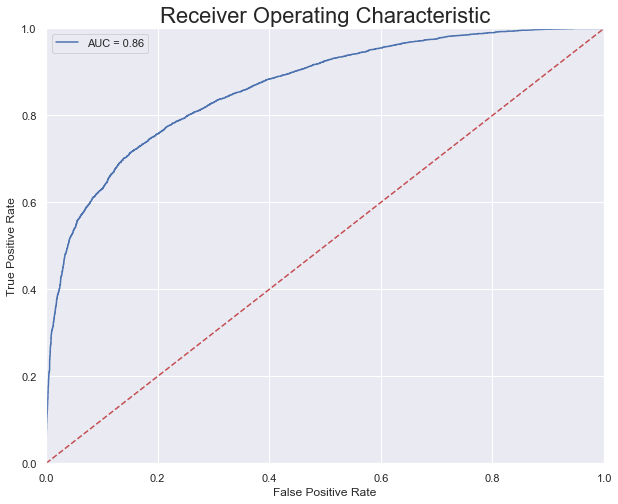

In [134]:
plt.figure(figsize = (10,8))
plt.title('Receiver Operating Characteristic',fontsize = 22)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

In [135]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
optimal_threshold

0.4992952842844912

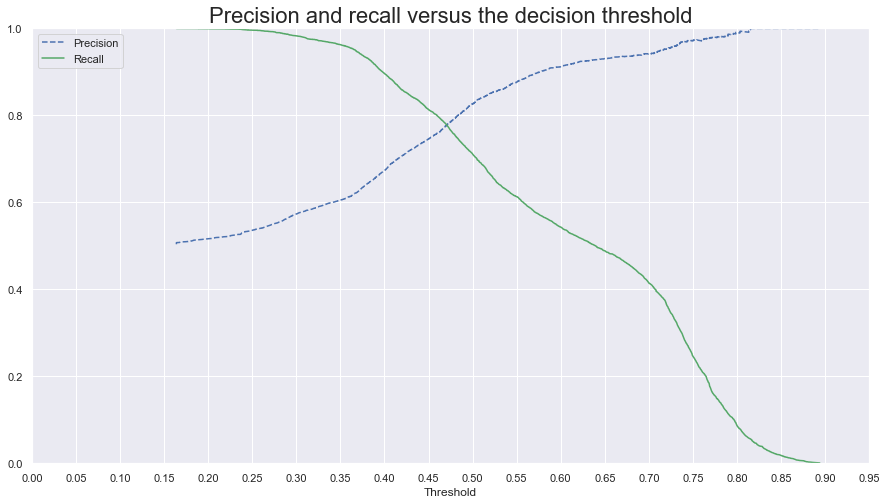

In [136]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize = (15,8))
    plt.title('Precision and recall versus the decision threshold',fontsize = 22)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.xticks(np.arange(0,1, 0.05))
    plt.ylim([0, 1])
    
precisions, recalls, thresholds = precision_recall_curve(y_under, y_pred)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

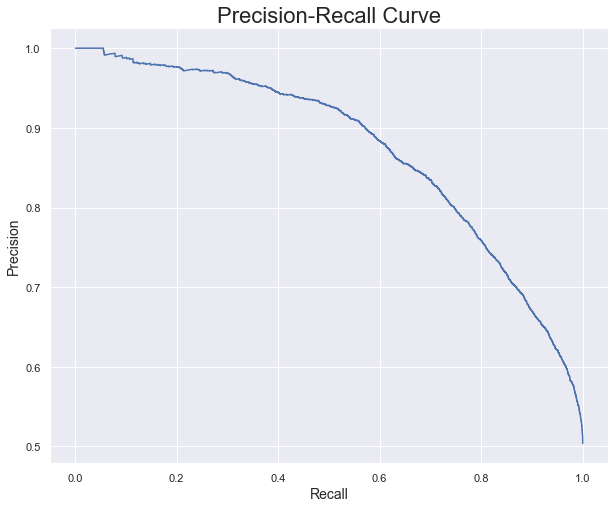

In [137]:
def PrecisionRecall(precisions, recalls, thresholds):
    plt.figure(figsize = (10,8))
    plt.title('Precision and recall versus the decision threshold')
    plt.plot(recalls[:-1], precisions[:-1], "b-")
    plt.xlabel('Recall', fontsize = 14)
    plt.ylabel('Precision', fontsize = 14)
    plt.title('Precision-Recall Curve', fontsize = 22)
    
precisions, recalls, thresholds = precision_recall_curve(y_under, y_pred)
PrecisionRecall(precisions, recalls, thresholds)
plt.show()

In [138]:
#random_final.classes_

In [139]:
# estimator = random_final.estimators_[6]

In [140]:
# from sklearn.tree import export_graphviz
# fn = X_under.columns.tolist()
# cn = ['No-Injuries', 'Injuries']
# # Export as dot file
# tree.export_graphviz(estimator, class_names=cn,
#                 feature_names=fn,
#                 out_file='tree.dot', 
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

In [141]:
# # Convert dot file into png
# !dot -Tpng -Gdpi=800 tree.dot -o tree_1.png

In [142]:
# #train.info()
# # avoinding to change to many things down. Therefore
# train_new=train.copy()

# Test Data Preprocessing and Prediction

In [143]:
#First filtering the data used for training
filter_list=["AGE","LANE_CNT","AIRBAG_DEPLOYED","PRIM_CONTRIBUTORY_CAUSE","POSTED_SPEED_LIMIT","NUM_UNITS","TRAFFICWAY_TYPE",  
             "SEC_CONTRIBUTORY_CAUSE","FIRST_CRASH_TYPE","MOST_SEVERE_INJURY","LIGHTING_CONDITION","SEX","CRASH_DATE",
             "CRASH_HOUR","VEHICLE_YEAR"]

test_new = raw_test[filter_list]

In [144]:
# converting variables alike train variables
test_new.loc[test_new["LIGHTING_CONDITION"]=="UNKNOWN","LIGHTING_CONDITION"]=np.nan
test_new.loc[test_new["TRAFFICWAY_TYPE"]=="UNKNOWN","TRAFFICWAY_TYPE"]=np.nan
test_new.loc[test_new["AIRBAG_DEPLOYED"]=="DEPLOYMENT UNKNOWN","AIRBAG_DEPLOYED"]=np.nan

In [145]:
# Filing NaN values after multiple tests

test_new.fillna({

    'LIGHTING_CONDITION': 'DAYLIGHT',
    'TRAFFICWAY_TYPE': 'NOT DIVIDED',
    'SEX': 'UNABLE TO DETERMINE',
    'AIRBAG_DEPLOYED': 'UNABLE TO DETERMINE',
}, inplace=True)

In [146]:
#test_new.isnull().sum()

In [147]:
drop_rows = ['MOST_SEVERE_INJURY']
test_new.dropna(how='any', subset=drop_rows, inplace = True)
#test_new.isnull().sum()

In [148]:
test_new['LANE_CNT']=pd.to_numeric(test_new['LANE_CNT'])
test_new['VEHICLE_YEAR']=pd.to_numeric(test_new['VEHICLE_YEAR'])
test_new['NUM_UNITS']=pd.to_numeric(test_new['NUM_UNITS'])
test_new["POSTED_SPEED_LIMIT"]=pd.to_numeric(test_new["POSTED_SPEED_LIMIT"])
test_new["AGE"]=pd.to_numeric(test_new["AGE"])

In [149]:
# Change all rows with value greater than 6 to 6
test_new['LANE_CNT'].fillna(2,inplace=True)
test_new.loc[(test_new['LANE_CNT'] > 6),'LANE_CNT'] = 6
test_new.loc[(test_new['LANE_CNT'] == 0),'LANE_CNT'] = 1
test_new['LANE_CNT'].value_counts()

2.0    11321
4.0     1097
1.0      879
3.0      183
6.0      146
5.0       40
Name: LANE_CNT, dtype: int64

In [150]:
# Applying functions to test data set
test_new["INJURY"] = test_new["MOST_SEVERE_INJURY"].apply(lambda x: injury(x))

In [151]:
test_new["AIRBAG_DEPLOYED"]= test_new["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))

In [152]:
test_new["CRASH_HOUR"] = test_new["CRASH_HOUR"].apply(lambda x: crash_hour(int(x)))

In [153]:
test_new["TRAFFICWAY_TYPE"]= test_new["TRAFFICWAY_TYPE"].apply(lambda x: traffic_way(x))

In [154]:
test_new["VEHICLE_AGE"]=test_new["CRASH_DATE"].dt.year-test_new["VEHICLE_YEAR"]
test_new.loc[test_new["VEHICLE_AGE"]<0,"VEHICLE_AGE"]=0
test_new.drop(["VEHICLE_YEAR","CRASH_DATE","MOST_SEVERE_INJURY"],axis=1,inplace=True)
test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13666 entries, 60889 to 36998
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AGE                      8894 non-null   float64
 1   LANE_CNT                 13666 non-null  float64
 2   AIRBAG_DEPLOYED          13666 non-null  object 
 3   PRIM_CONTRIBUTORY_CAUSE  13666 non-null  object 
 4   POSTED_SPEED_LIMIT       13666 non-null  int64  
 5   NUM_UNITS                13666 non-null  int64  
 6   TRAFFICWAY_TYPE          13666 non-null  object 
 7   SEC_CONTRIBUTORY_CAUSE   13666 non-null  object 
 8   FIRST_CRASH_TYPE         13666 non-null  object 
 9   LIGHTING_CONDITION       13666 non-null  object 
 10  SEX                      13666 non-null  object 
 11  CRASH_HOUR               13666 non-null  object 
 12  INJURY                   13666 non-null  object 
 13  VEHICLE_AGE              11193 non-null  float64
dtypes: float64(3), int

In [155]:
# splitting the dataset into x_train and y_train
X_test = test_new.drop(["INJURY"],axis=1)
y_test = test_new["INJURY"]

In [156]:
# performing one hot encoding on all the object features
X_test = pd.get_dummies(X_test, columns=X_test.select_dtypes(['object']).columns)

In [157]:
dummies_to_drop = X_test.columns[X_test.columns.str.contains("UNABLE|UNKNOWN|NOT APPLICABLE|OTHER")]
X_test = X_test.loc[:, ~X_test.columns.isin(dummies_to_drop)]

In [158]:
#X_test.info()

In [159]:
X_test["SEC_CONTRIBUTORY_CAUSE_PASSING STOPPED SCHOOL BUS"]=0

In [160]:
X_test = X_test[X_train.columns]

In [161]:
df = pd.DataFrame(imputer.transform(X_test),columns = X_test.columns)
X_test=df.copy()
X_test=np.round(X_test)

In [162]:
y_test_new = (y_test == "INJURED")
y_test_new = y_test_new.astype(int)

In [163]:
y_pred_final = model.predict(X_test)

In [164]:
#y_pred_final

## Test prediction results

In [165]:
from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(y_test_new, y_pred_final))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.89     12276
           1       0.33      0.70      0.44      1390

    accuracy                           0.82     13666
   macro avg       0.64      0.77      0.67     13666
weighted avg       0.90      0.82      0.85     13666



In [166]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_new, y_pred_final)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_new, y_pred_final)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_new, y_pred_final)
print('Recall: %f' % recall)

Accuracy: 0.821601
Precision: 0.325333
Recall: 0.702158


In [167]:
y_pred_final = model.predict_proba(X_test)
y_pred_final = y_pred_final[:,1]

In [168]:
fpr, tpr, threshold = roc_curve(y_test_new, y_pred_final)
roc_auc = auc(fpr, tpr)

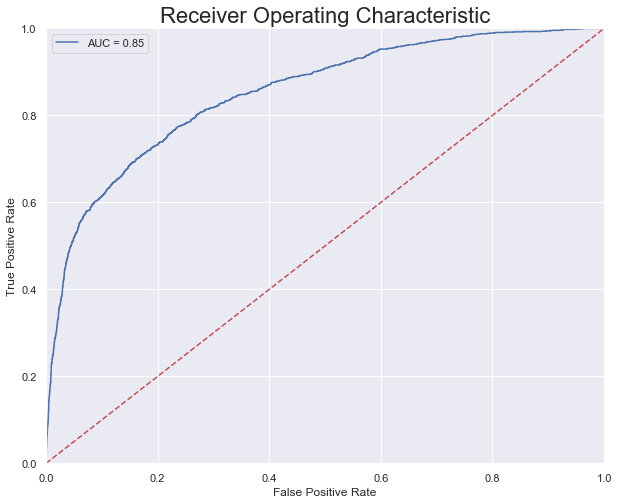

In [169]:
plt.figure(figsize = (10,8))
plt.title('Receiver Operating Characteristic',fontsize = 22)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

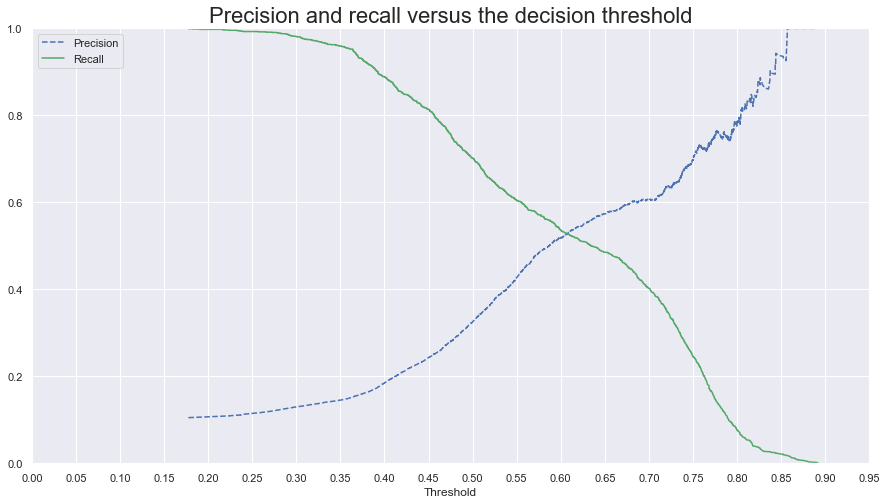

In [170]:
precisions, recalls, thresholds = precision_recall_curve(y_test_new, y_pred_final)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

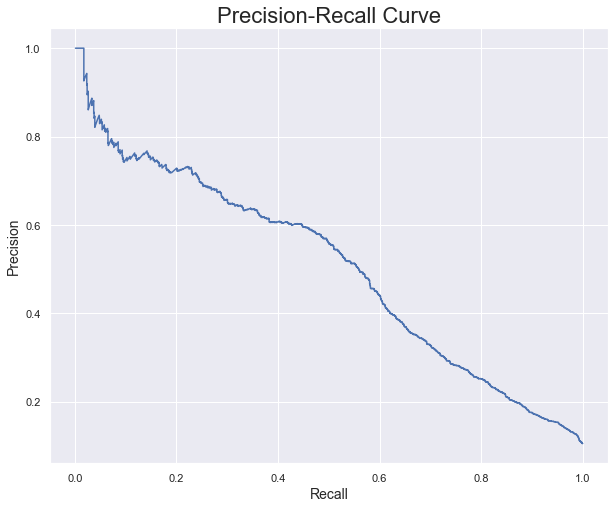

In [171]:
precisions, recalls, thresholds = precision_recall_curve(y_test_new, y_pred_final)
PrecisionRecall(precisions, recalls, thresholds)
plt.show()

In [172]:
#plt.figure(figsize = (10,8))
#df = train_new[(train_new.INJURY == 'NOT INJURED') & (train_new.VEHICLE_AGE < 50)]
#sns.distplot(df['VEHICLE_AGE'], bins=20, kde=False, label='NOT INJURED')

#df =train_new[(train_new.INJURY == 'INJURED')]
#sns.distplot(df['VEHICLE_AGE'], bins=50, kde=False,label='INJURED')

# Plot formatting
#plt.legend(prop={'size': 12})
#plt.xlim([0, 50])
#plt.title('Vehicle Age involved in Crashes',fontsize=20)
#plt.xlabel('VEHICLE_AGE')
#plt.ylabel('Density')

In [173]:
#plt.figure(figsize = (10,8))
#df =train_new[(train_new.INJURY == 'NOT INJURED') & (train.VEHICLE_AGE.isin(range(0,2)))]
#sns.distplot(df['AGE'], bins=30, kde=False,label='NOT INJURED')

#df =train_new[(train_new.INJURY == 'INJURED') & (train.VEHICLE_AGE.isin(range(0,2)))]
#sns.distplot(df['AGE'], bins=30, kde=False,label='INJURED')

# Plot formatting
#plt.legend(prop={'size': 12})
#plt.title('Age of drivers involved in crash of new cars',fontsize=20)
#plt.xlim([10, 80])
#plt.xlabel('AGE')
#plt.ylabel('Density')

# Take home messages

## Partial dependence of Age!

- **Can see that age between 20 - 30 and age above 55 are more likely to get injured in crashes**


- **Possible solution - Target the group through school/colleges, elder audience through organisations and impart education and awareness**

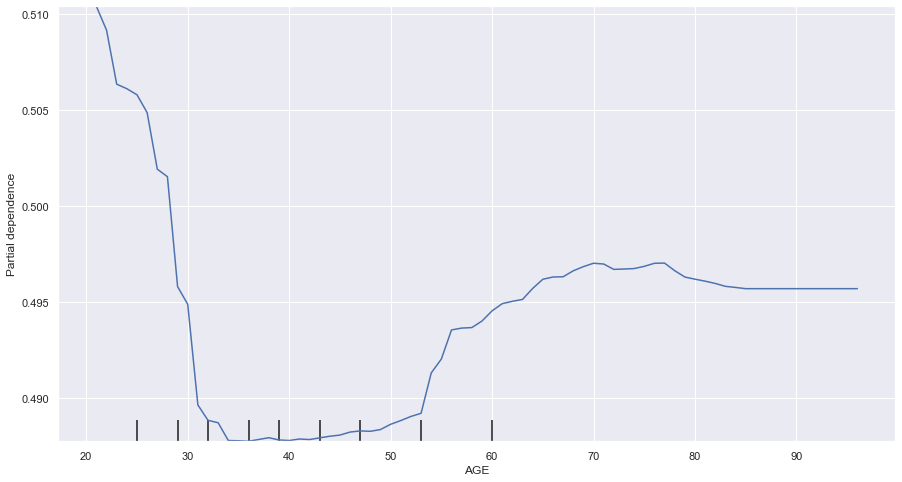

In [174]:
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize = (15,8))
plot_partial_dependence(random_final, features = ['AGE'], # column numbers of plots we want to show
                        X = X_under[X_under['AGE']>20],
                        fig = fig) # number of values to plot on x axis

plt.show()

## Partial dependence of Lane Count

- **Crashes are more injury prone when they take place on a wider road (highways)**

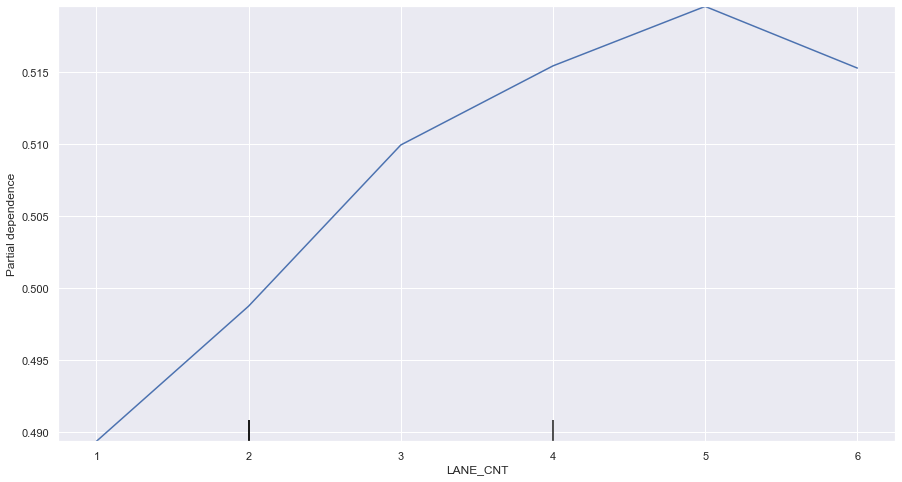

In [175]:
from sklearn.inspection import plot_partial_dependence

fig = plt.figure(figsize = (15,8))
plot_partial_dependence(random_final, features = ['LANE_CNT'], # column numbers of plots we want to show
                        X = X_under,
                        fig = fig) # number of values to plot on x axis

plt.show()

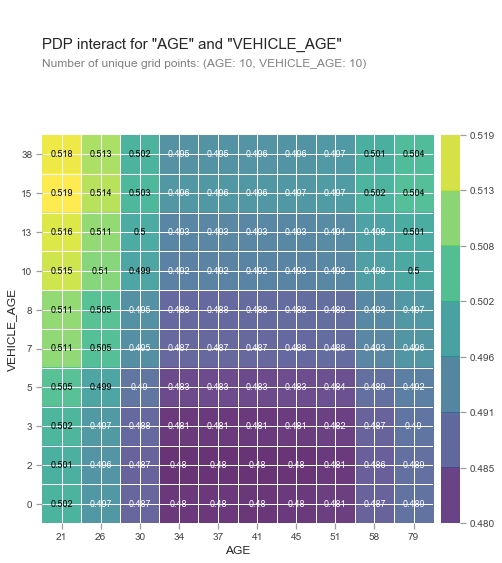

In [189]:
from pdpbox import pdp, get_dataset, info_plots

inter1 = pdp.pdp_interact(
   model = random_final, dataset = X_under[((X_under['AGE']>20) & (X_under['AGE']<80)) & ((X_under['VEHICLE_AGE']<40))],
   model_features = X_under.columns.tolist(), features=['AGE', 'VEHICLE_AGE'])

fig, axes = pdp.pdp_interact_plot(inter1, ['AGE', 'VEHICLE_AGE'], plot_type='grid',  plot_pdp = False)

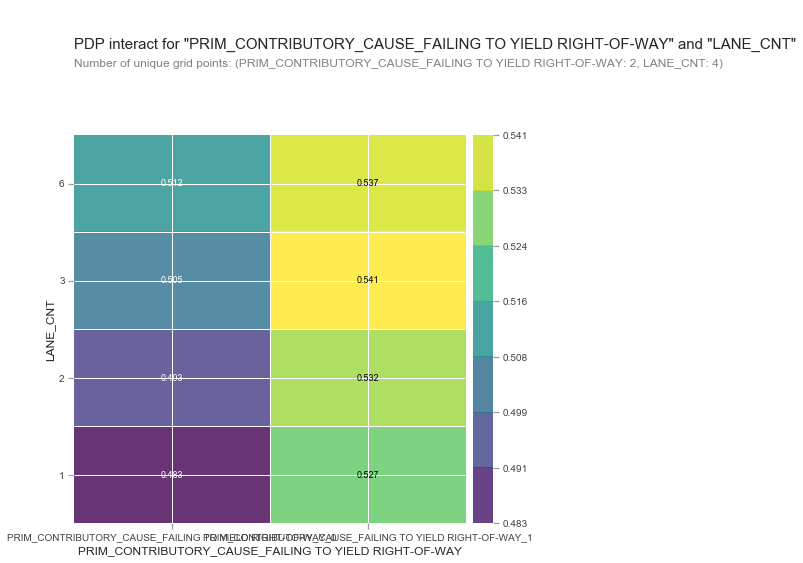

In [191]:
inter1 = pdp.pdp_interact(
    model = random_final, dataset = X_under, model_features = X_under.columns.tolist(), features=['PRIM_CONTRIBUTORY_CAUSE_FAILING TO YIELD RIGHT-OF-WAY', 'LANE_CNT'])

fig, axes = pdp.pdp_interact_plot(inter1, ['PRIM_CONTRIBUTORY_CAUSE_FAILING TO YIELD RIGHT-OF-WAY', 'LANE_CNT'], plot_type='grid',  plot_pdp = False)

## Primary Cause - DISREGARDING TRAFFIC SIGNALS

- Here we can see that 6% of total injury crashes were caused because of **"DISREGARDING TRAFFIC SIGNALS"**

- This figure is 4 times compared to Non-injury crashes.

**Solution:**
- Have heavy penalty for such cases
- Stricker actions

In [192]:
df=train_new
x,y = 'PRIM_CONTRIBUTORY_CAUSE', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()
df1 = df1[df1["PRIM_CONTRIBUTORY_CAUSE"]=="DISREGARDING TRAFFIC SIGNALS"]

Text(0.5, 1.0, 'Caused by Disregarding Traffic Signal')

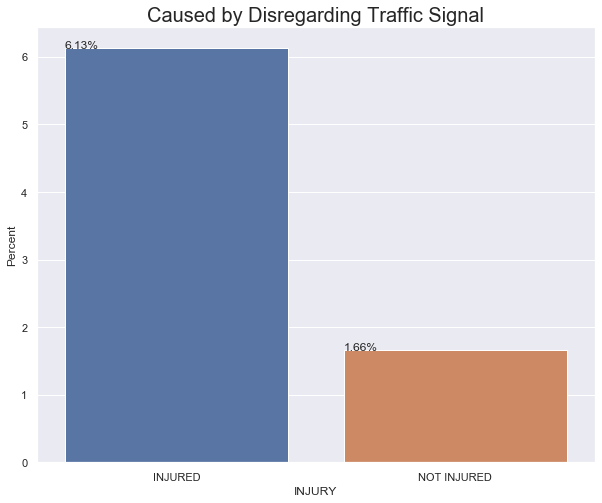

In [193]:
fig = plt.figure(figsize = (10,8))
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

plt.title("Caused by Disregarding Traffic Signal",fontsize=20)

## Primary Cause - FAILING TO YIELD RIGHT-OF-WAY

- Here we can see that 20% of total injury crashes were caused because of **"FAILING TO YIELD RIGHT-OF-WAY"**

- This figure is double compared to Non-injury crashes.

**Solution:**
- Put traffic control signal or speed limit at intersection/turning points.
- Create more awareness regarding this

In [194]:
df=train_new
x,y = 'PRIM_CONTRIBUTORY_CAUSE', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()
df1 = df1[df1["PRIM_CONTRIBUTORY_CAUSE"]=="FAILING TO YIELD RIGHT-OF-WAY"]

Text(0.5, 1.0, 'Caused by Failing to Yield Right-of-way')

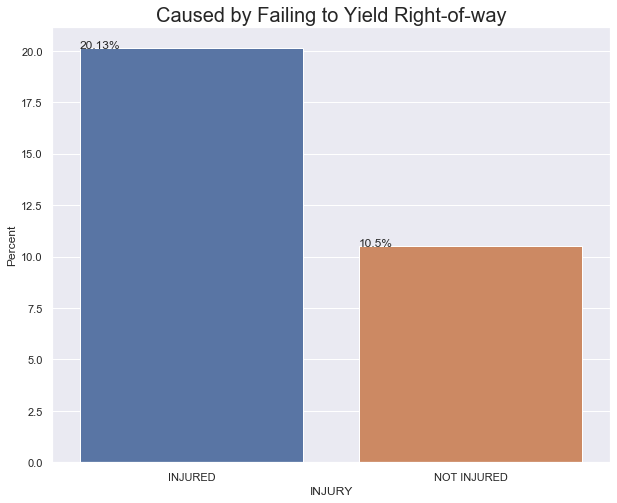

In [195]:
fig = plt.figure(figsize = (10,8))
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)
plt.title("Caused by Failing to Yield Right-of-way",fontsize=20)

## Primary Cause - FAILING TO REDUCE SPEED TO AVOID CRASH

- Here we can see that 8.81% of total injury crashes were caused because of **"FAILING TO REDUCE SPEED TO AVOID CRASH"**

- This figure is 2 times compared to Non-injury crashes.

**Solution:**
- Have compulsory ABS system in vehicles

In [204]:
df=train_new
x,y = 'PRIM_CONTRIBUTORY_CAUSE', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()
df1 = df1[df1["PRIM_CONTRIBUTORY_CAUSE"]=="FAILING TO REDUCE SPEED TO AVOID CRASH"]

Text(0.5, 1.0, 'Caused by Failing to reduce speed to avoid crash')

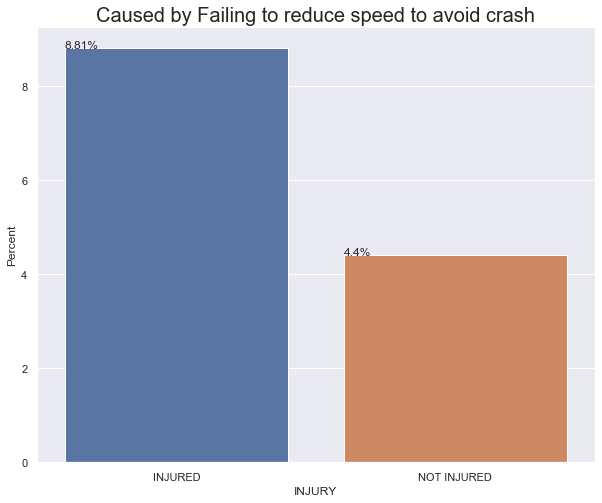

In [205]:
fig = plt.figure(figsize = (10,8))
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)
plt.title("Caused by Failing to reduce speed to avoid crash",fontsize=20)    

## Airbag deployment and Injuries

- Here we can see that in 20% of total injury crashes were caused when **AIRBAGS were deployed** compared to 3% of Non-injury

- This figure represents that the airbags were not able to stop serious injuries or maybe inefficient Airbag deployments must have caused injuries

**Solution:**
- Check into Airbags and related regulation of Car companies

In [206]:
df=train_new
x,y = 'AIRBAG_DEPLOYED', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
df1 = df1[df1["AIRBAG_DEPLOYED"]=="DEPLOYED"]

Text(0.5, 1.0, 'Airbags deployed in crashes')

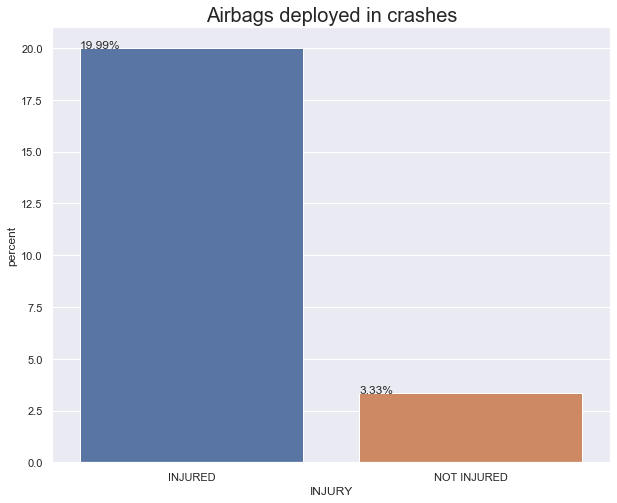

In [207]:
fig = plt.figure(figsize = (10,8))
ax = sns.barplot(x="INJURY", y="percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)
plt.title("Airbags deployed in crashes",fontsize=20)

## Crashes at night and Injuries

- Crashes at night are more injury prone than other time of the day

Text(0.5, 1.0, 'Crashes at night time')

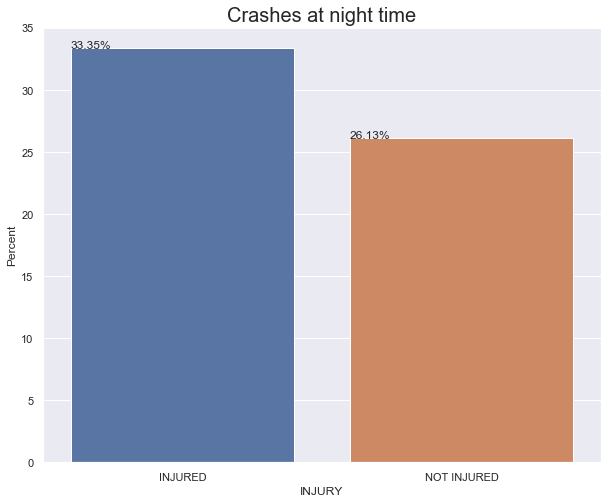

In [208]:
df=train
x,y = 'CRASH_HOUR', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
df1 = df1[df1["CRASH_HOUR"]=="Night"]

fig = plt.figure(figsize = (10,8))
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)
plt.title("Crashes at night time",fontsize=20)

## Aged group
**Different Age group has different attributing contributor**

In [209]:
def age_group(x):
    if  0.0 <= x <= 18.0:
        return "below 18"
    elif 18.0 < x <= 30.0:
        return "between 19 and 30"
    elif 30.0< x <= 40.0:
        return "between 31 and 40"
    elif 40.0< x <= 50.0:
        return "between 41 and 50"
    elif 50.0< x <= 60.0:
        return "between 51 and 60"
    else:
        return "Over 60"
    
# replacing NA values with OTHER
df["AGE_binned"] = df["AGE"].apply(lambda x: age_group(int(x)))
#df.groupby(['AGE_binned']).size()

**Age Group of below have more injured% > not-injured%**
- Between 19~30
- Over 60 
- Under 18

Text(0.5, 1.0, 'Age group involved in crash')

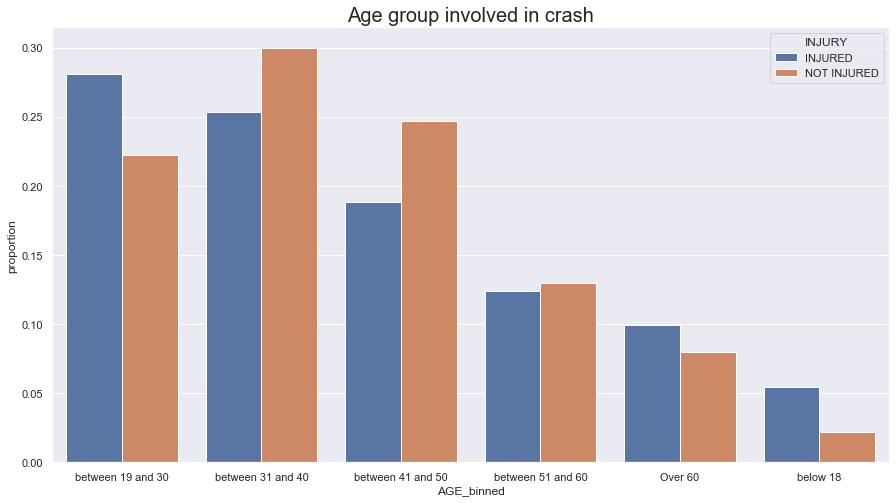

In [210]:
df=train
x, y, hue = "AGE_binned", "proportion", "INJURY"
hue_order = ["Not Injured", "Injured"]
plt.figure(figsize = (15,8))

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))
plt.title("Age group involved in crash",fontsize=20)

## Safety equipment usage
**Used safety equipment has less injured - can be used to educate citizens"**

Text(0.5, 1.0, 'Safety equipment usage in crash')

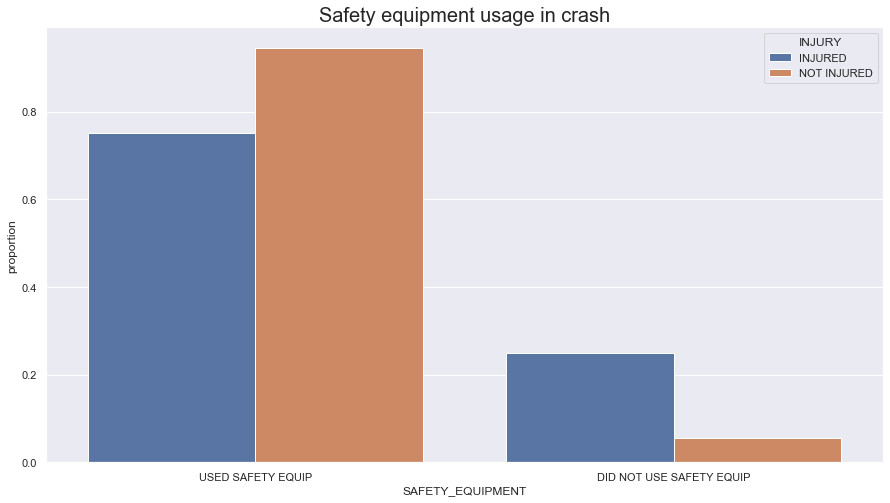

In [212]:
train_new1 = train[~train['SAFETY_EQUIPMENT'].isin(['CHILD RESTRAINT - TYPE UNKNOWN', 'UNABLE TO DETERMINE','WHEELCHAIR'])]
df1=train_new1
#display(df1.groupby(['SAFETY_EQUIPMENT']).size())
x, y, hue = "SAFETY_EQUIPMENT", "proportion", "INJURY"
hue_order = ["Not Injured", "Injured"]
plt.figure(figsize = (15,8))

(df1[x]
 .groupby(df1[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))
plt.title("Safety equipment usage in crash",fontsize=20)

## Summary of traffic control devices and its condition

- **54% of fatalities** and **45% of injuries** happened in roads with **no control devices**.
- **50% of fatalities** and **48% of injuries** happened in roads with **control devices whose conditions are not controlled.**

In [215]:
def injury_fatality_summarizer(col, df=train):
    x=df[df['INJURY']=='INJURED'][col].value_counts(normalize=True).reset_index(name='injury').sort_values(["index"])
    y=df[df['FATALITIES']=='FATAL'][col].value_counts(normalize=True).reset_index(name='fatal').sort_values(["index"])
    
    table=x.merge(y, how='inner', on=['index']).sort_values(['fatal','injury'], ascending=False)
    table=table.rename(columns={'index':col, 'injury':'PERCENTAGE OF INJURIES', 'fatal':'PERCENTAGE OF FATALITIES'})
    return(table)

In [216]:
injury_fatality_summarizer('TRAFFIC_CONTROL_DEVICE')

,TRAFFIC_CONTROL_DEVICE,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,NO_SIGN,0.454515,0.546875
1,SIGN,0.545485,0.453125


In [217]:
injury_fatality_summarizer('DEVICE_CONDITION')

,DEVICE_CONDITION,PERCENTAGE OF INJURIES,PERCENTAGE OF FATALITIES
0,FUNCTIONING PROPERLY,0.496775,0.5
1,NO CONTROLS,0.483367,0.5


## Further insights

- The highest probability of getting injured is when the occupant number equals to 3 **(More than 18.73 %)**

- Crashes involving PEDALCYCLIST, and PEDESTRIAN lead to having more injuries than non-injuries

- Apart from above, ANGLE, HEAD-ON, OVERTURNED, and TURNING have a high probabilities of getting injured from all cases

- FOLLOWING TOO CLOSELY is the main reason of crashes for age 30-40, 40-50, 50-60, and 60 + because FAILING TO REDUCE SPEED TO AVOID CRASH

- Primary cause is mostly identical for both females and males

- There is no indication that WORK_ZONE and POSTED_SPEED_LIMIT have an effect on injuries or fatalities 

- The incidence of accidents with injuries in “mid” speed areas (25-40mph) occurs almost twice as often as the other areas (<25 and >40) and the fatalities only occur in the mid speed areas!

# Other models - will try later

In [218]:
# filter_list=["AIRBAG_DEPLOYED","PRIM_CONTRIBUTORY_CAUSE","SEC_CONTRIBUTORY_CAUSE","VEHICLE_AGE","Location","FATALITIES"]

# train_new = train[filter_list]

In [219]:
# # splitting the dataset into x_train and y_train
# X_train = train_new.drop(["FATALITIES"],axis=1)
# y_train = train_new["FATALITIES"]

In [220]:
#X_train.info()

In [ ]:
# # performing one hot encoding on all the object features
# X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns, drop_first=True)

In [ ]:
# X_train.shape

In [ ]:
# #Encode the y_train labels
# lb = preprocessing.LabelBinarizer()
# y_train=lb.fit_transform(y_train)

In [ ]:
# #Create a Random Forest Classifier
# clf=RandomForestClassifier(n_estimators=100)

# #Train the model using the training sets y_pred=clf.predict(X_test)
# scores = cross_val_score(clf, X_train, y_train, cv=5)
# print('Accuracy', np.mean(scores), scores)

In [ ]:
# recall = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
# print('Recall', np.mean(recall), recall)
# precision = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
# print('Precision', np.mean(precision), precision)
# f1 = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
# print('F1', np.mean(f1), f1)

In [ ]:
# #Create a Random Forest Classifier
# clf=RandomForestClassifier(n_estimators=100)
# clf.fit(X_train,y_train)
# print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

In [ ]:
# df=train_new
# x,y = 'PRIM_CONTRIBUTORY_CAUSE', 'FATALITIES'

# df1 = df.groupby(y)[x].value_counts(normalize=True)
# df1 = df1.mul(100)
# df1 = df1.rename('percent').reset_index()
# df1 = df1[df1["PRIM_CONTRIBUTORY_CAUSE"]=="PHYSICAL CONDITION OF DRIVER"]
# df1

In [ ]:
# ax = sns.barplot(x="FATALITIES", y="percent", data=df1)
# for p in ax.patches:
#     txt = str(p.get_height().round(2)) + '%'
#     txt_x = p.get_x() 
#     txt_y = p.get_height()
#     ax.text(txt_x,txt_y,txt)
    

In [ ]:
# df=train_new
# x,y = 'AIRBAG_DEPLOYED', 'FATALITIES'

# df1 = df.groupby(y)[x].value_counts(normalize=True)
# df1 = df1.mul(100)
# df1 = df1.rename('percent').reset_index()
# df1 = df1[df1["AIRBAG_DEPLOYED"]=="DEPLOYED"]

In [ ]:
# ax = sns.barplot(x="FATALITIES", y="percent", data=df1)
# for p in ax.patches:
#     txt = str(p.get_height().round(2)) + '%'
#     txt_x = p.get_x() 
#     txt_y = p.get_height()
#     ax.text(txt_x,txt_y,txt)
    

In [ ]:
# from sklearn.inspection import plot_partial_dependence

# fig = plt.figure(figsize = (15,8))
# plot_partial_dependence(clf, features = ['VEHICLE_AGE'], # column numbers of plots we want to show
#                         X = X_train,
#                         fig = fig) # number of values to plot on x axis

# plt.show()

In [ ]:
# df = train_new[train_new.FATALITIES == 'NOT FATAL']
# sns.distplot(df['VEHICLE_AGE'],  kde=False, label='NOT FATAL')

# df =train_new[train_new.FATALITIES == 'FATAL']
# sns.distplot(df['VEHICLE_AGE'],  kde=False,label='FATAL')

# # Plot formatting
# plt.legend(prop={'size': 12})
# plt.title('Life Expectancy of Two Continents')
# plt.xlabel('VEHICLE_AGE)')
# plt.ylabel('Density')